# About this Project
In this project, I've worked with a dataset containing 25.9k unique transactions from a UK-based online retail store. The main goal here is to explore the data thoroughly, find interesting insights, and use them to improve business decisions. To do this, I've used various techniques, including data manipulation, exploring the data's patterns, customer segmentation, and forecasting future sales using various Machine Learning models.

Dataset source: https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

from itertools import combinations
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use("ggplot")

## Loading the Dataset

In [2]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1', parse_dates = ["InvoiceDate"])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Understanding
- This stage encompasses a thorough understanding of the dataset. This involves identifying basic information such as dataframe shape and data types of each column, analyzing summary statistics for numeric and non-numeric variables, identifying missing values and duplicate entries, and verifying the consistency of the datetime column, if there are any missing gaps in the data. Additionally, this includes checking other information such as cancelled/returned orders and invalid descriptions.

### Dataset Overview

In [3]:
# Shape of the dataframe
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataframe. \n")

# Basic Information
df.info()

There are 541909 rows and 8 columns in the dataframe. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above result, we can infer the following:
1. The dataset is consists of 541909 entries (rows) and 8 columns.
2. The dataset contains 3 numerical (int,float) and 4 non-numerical (object) variables.
3. There are less entries in Description and CustomerID column so this means that there are missing values in the dataset.

### Column Descriptions
1. InvoiceNo - a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
2. StockCode - a 5-digit integral number uniquely assigned to each distinct product
3. Description - product name
4. Quantity - the quantities of each product (item) per transaction
5. InvoiceDate - the day and time when each transaction was generated
6. UnitPrice - product price per unit
7. CustomerID - a 5-digit integral number uniquely assigned to each customer
8. Country - the name of the country where each customer resides

### Summary Statistics

In [4]:
# For Numerical Variables
print("Summary Statistics for numerical variables:")
display(df.describe(include = [float, int]))
print("-"*100)
# For Non-Numerical Variables
print("Summary Statistics for non-numerical variables:")
display(df.describe(exclude = [float, int]))

Summary Statistics for numerical variables:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


----------------------------------------------------------------------------------------------------
Summary Statistics for non-numerical variables:


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495478
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN


Inference from the above result:
1. By looking at the quantity column, we can deduce that the mean quantity of items in a transaction is roughly 9.5. Additionally, the range of values spans from -80995 to 80995. The occurrence of negative values suggests that some orders were either canceled or returned. Furthermore, outliers are present in this column, as evidenced by the huge difference between the maximum value and the 75th percentile.
2. The UnitPrice shows that the average price for a product is approximately 4.6. It also has a similar issue to the Quantity column as it has a wide range ov values with negative as its minimum. This suggests that there are errors in the records as its impossible to have a negative price. Outliers are also present as evidenced by the huge difference between the maximum value and the 75th percentile.
3. CustomerID only has 406829 non-null entries which means that there are missing values in this column.
4. InvoiceNo contains 25900 unique values also implies the total number of unique transactions in the dataset. It also shows the most frequent InvoiceNo which is 573585 appearing 1114 times in the dataset.
5. StockCode contains 4070 unique values with 85123A appearing the most frequent.
6. The count for the Description column is less than the number of total entries in the dataset. This means that missing values are also present in this column. It also shows that 'WHITE HANGING HEART T-LIGHT HOLDER' appeared the most frequent in the column, possibly the most bought product.
7. The InvoiceDate column shows that the first transaction in the dataset was recorded on '2010-12-01 08:26:00' while the most recent was on '2011-12-09 12:50:00'. This implies that the dataset contains more than 1 year of recorded transactions.
8. Finally, the dataset contains 38 unique countries with United Kingdom appearing 495478 times which is approximately 91% of all the transactions.

### Checking for Missing and Duplicate Values

In [5]:
# Missing values
print("Count of missing values per column:")
display(df.isna().sum())
print("\n")
# Duplicate values
print("Count of duplicate values:")
display(df.duplicated().sum())

Count of missing values per column:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64



Count of duplicate values:


5268

We can see that the CustomerID has 135080 missing values which is 24.9% of the total entries while Description has 1454 missing values. There are also 5268 duplicate values in the dataset.

In [6]:
# Sample duplicates
df.loc[df.duplicated(keep=False)].sort_values(by = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


### Checking for Missing Dates

In [7]:
min_date = df.InvoiceDate.dt.date.min()
max_date = df.InvoiceDate.dt.date.max()

date_range = pd.date_range(min_date, max_date)

missing_dates = date_range.difference(df.InvoiceDate.dt.date.unique())
num_missing_dates = len(missing_dates)
print(f"Start Date: {min_date}")
print(f"End Date: {max_date}")
print(f"There are {num_missing_dates} missing dates in the dataset.")
print("The missing dates: ")
display(missing_dates)

Start Date: 2010-12-01
End Date: 2011-12-09
There are 69 missing dates in the dataset.
The missing dates: 


DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
               '2011-08-20', '2011-08-27', '2011-08-29', '2011-09-03',
      

Except for missing dates due to Christmas Holiday (2010-12-24 to 2010-01-03), most missing dates in the dataset has a seven day or one week interval. This suggests that the retail shop possibly didn't accept transactions on a specific day of the week. For the sake of a better understanding of how the shop works, I will check the day these missing values occured.

In [8]:
# Creating a dataframe of missing dates
missing_dates_df = pd.DataFrame(data = missing_dates, columns = ["Date"])

# Creating a day of week column
missing_dates_df["Dayofweek"] = missing_dates_df.Date.dt.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                                                                        3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Checking the number of missing dates in each day of the week
print(f"Number of missing dates per day of the week: ")
print(missing_dates_df.Dayofweek.value_counts())

Number of missing dates per day of the week: 
Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: Dayofweek, dtype: int64


We can observe that no transactions took place on 53 Saturdays, which is approximately equivalent to a year without Saturday.

### Checking for Cancelled/Returned Orders

In [9]:
# Cancelled/Returned Orders
df.loc[df.InvoiceNo.str.contains("C")].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
294217,C562687,22268,DECORATION SITTING BUNNY,-39,2011-08-08 13:53:00,0.19,15157.0,United Kingdom
382807,C569959,23224,CHERUB HEART DECORATION GOLD,-2,2011-10-06 18:39:00,0.83,13983.0,United Kingdom
73742,C542376,M,Manual,-2,2011-01-27 13:44:00,2.55,13777.0,United Kingdom
244399,C558521,15058B,PINK POLKADOT GARDEN PARASOL,-2,2011-06-30 10:31:00,6.75,13113.0,United Kingdom
14528,C537602,22654,DELUXE SEWING KIT,-1,2010-12-07 12:45:00,4.95,17511.0,United Kingdom


Orders that have been cancelled or returned are identifiable by the presence of a 'C' in the InvoiceNo and a negative number in the Quantity column.

There are also orders that were not cancelled nor returned but has a negative quantity, possibly an error.

In [10]:
# Other orders with negative quantity neither cancelled nor returned
negative_quantity_orders = df.loc[(~(df.InvoiceNo.str.contains("C"))) & (df.Quantity.lt(0))]
negative_quantity_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


As shown above, there are 1336 rows that aren't labeled as cancelled or returned orders but have a negative quantity. Furthermore, in the last part (tail) of the result, it can be seen that there are values in the Description column that are very unlikely to be a valid description.  It's noteworthy that these entries also have null values in the CustomerID column, which could potentially signify an error.

## Data Cleaning 
- This step addresses the observations made in the previous stage. This includes dealing with missing and duplicate values, removing cancelled/returned orders, and making additional adjustments necessary to prepare the data for in-depth analysis and modeling.

In [11]:
# Making a copy of the dataframe
clean_df = df.copy()

### Handling Missing Values

As previously discovered, the only columns with missing values are CustomerID and Description. In this case, I'll use the pandas dropna() method to remove all null values from the CustomerID. Regarding the null values in the Description, it is crucial to identify whether it is an invalid order or simply an order with no description.

In [12]:
# Dropping missing values in CustomerID
clean_df = clean_df.dropna(subset = "CustomerID")

# Checking the number of rows of the dataframe before and after dropping the null values
before_dropping = df.shape[0]
after_dropping = clean_df.shape[0]
total_rows_drop = before_dropping - after_dropping

print(f"The original dataframe contains {before_dropping} rows and were reduced to {after_dropping} after dropping. In total, {total_rows_drop} rows were dropped.")

The original dataframe contains 541909 rows and were reduced to 406829 after dropping. In total, 135080 rows were dropped.


In [13]:
# Checking the missing values for the Description column
clean_df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

It seems that the missing values in the Description column were also dropped along with the missing values in the CustomerID. This indicates that every row with a missing Description value also has a missing CustomerID value. Therefore, all the rows with missing values are invalid orders. 

### Handling Duplicate Values

It is not possible to have a completely identical rows so it is best to remove it from the dataset. I will use the drop_duplicates() method to remove duplicates and only keep the first occurence.

In [14]:
# Excluding duplicate values
clean_df = clean_df.drop_duplicates()
print(f"Shape of the dataframe after removing duplicates: {clean_df.shape}")

Shape of the dataframe after removing duplicates: (401604, 8)


As can be seen from the above result, we only have 401604 records in the dataframe after removing 5225 duplicate rows.

### Handling Cancelled or Returned Orders

In [15]:
# Making an empty column to identify cancelled orders
clean_df["is_Cancelled"] = {}

# Update the is_Cancelled column to label transactions with 'C' in InvoiceNo as 1
clean_df.loc[clean_df.InvoiceNo.str.contains('C'), "is_Cancelled"] = 1
clean_df = clean_df.fillna(0) # Filling other values with 0 representing a 'completed' order.

# Locating rows that represent cancelled orders
cancelled_orders = clean_df.loc[clean_df.is_Cancelled.eq(1)]
display(cancelled_orders.head())

print("-"*140)

# Checking the number of cancelled orders
no_of_cancelled_orders = cancelled_orders.InvoiceNo.nunique()
total_orders = clean_df.InvoiceNo.nunique()
percent_of_cancelled_orders = round((no_of_cancelled_orders/total_orders*100), 2)
print(f"There are a total of {no_of_cancelled_orders} cancelled orders in the dataset or {percent_of_cancelled_orders}% of the total.")
print("-"*140)

# Checking the summary statistics of cancelled_orders
cancelled_orders.describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1.0


--------------------------------------------------------------------------------------------------------------------------------------------
There are a total of 3654 cancelled orders in the dataset or 16.47% of the total.
--------------------------------------------------------------------------------------------------------------------------------------------


,Quantity,UnitPrice,CustomerID,is_Cancelled
count,8872.000000,8872.000000,8872.000000,8872.0
mean,-30.774910,18.899512,14990.152953,1.0
std,1172.249902,445.190864,1708.230387,0.0
min,-80995.000000,0.010000,12346.000000,1.0
25%,-6.000000,1.450000,13505.000000,1.0
50%,-2.000000,2.950000,14868.000000,1.0
75%,-1.000000,4.950000,16393.000000,1.0
max,-1.000000,38970.000000,18282.000000,1.0


In the summary statistics above, it can be observe all cancelled orders contains negative values in the Quantity column as indicated by the minimum and maximumv values.

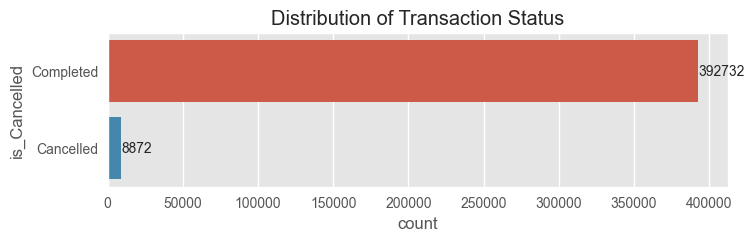

In [16]:
# Visualizing the distribution of cancelled an n
plt.figure(figsize=(8,2))
ax = sns.countplot(data = clean_df, y = "is_Cancelled")
plt.bar_label(ax.containers[0])
plt.title("Distribution of Transaction Status")
plt.yticks(ticks = [status for status, df in clean_df.groupby("is_Cancelled")], labels = ["Completed", "Cancelled"])
plt.show()

### Handling Anomalies in StockCode and Description columns

As I mentioned earlier, there seem to be descriptions in the dataset that appear to be invalid or questionable. Additionally, I've observed discrepancies in the StockCode column, where some values do not follow the expected five-digit format. These anomalies only have a single word description which is different from the majority and some StockCode entries include a letter or words.

In [17]:
# Checking invalid StockCodes in the dataframe
invalid_stockcode = clean_df[clean_df['StockCode'].str.contains(r'^[^\d]+$')]
unique_invalid_stockcode = invalid_stockcode.StockCode.unique()
percentage_invalid_stockcode = round((invalid_stockcode.shape[0]/clean_df.shape[0]) * 100, 2)

# Display invalid stock codes
display(invalid_stockcode.head())
print("-"*140)
print(f"Unique Invalid StockCodes: {unique_invalid_stockcode.tolist()}")
print(f"There are {invalid_stockcode.shape[0]} rows with invalid stock codes or {percentage_invalid_stockcode} of the total.")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_Cancelled
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,0.0
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1.0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,0.0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,0.0
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,0.0


--------------------------------------------------------------------------------------------------------------------------------------------
Unique Invalid StockCodes: ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']
There are 1781 rows with invalid stock codes or 0.44 of the total.


As shown above, there are StockCode values that deviate from the expected five-digit format and the same holds true for their corresponding Description values, which are vary unlikely to represent product descriptions. Therefore, it is best to remove these to keep our data consistent, with no irregularities.

In [18]:
# Removing invalid Stock Codes
clean_df = clean_df.loc[~clean_df.StockCode.isin(unique_invalid_stockcode)]

There are also zero UnitPrice values in the dataset, this might be products that are freebies or in promotions.

In [19]:
# Zero UnitPrice
print(f"Number of Zero UnitPrice: {clean_df.UnitPrice.eq(0).sum()}")

# Removing 0 UnitPrice 
clean_df = clean_df.loc[clean_df.UnitPrice.gt(0)]

Number of Zero UnitPrice: 33


### Dataset after Cleaning

In [20]:
# Shape of the dataset
before_cleaning = df.shape
after_cleaning = clean_df.shape
total_rows_removed = before_cleaning[0] - after_cleaning[0]

print(f"Shape before cleaning: {before_cleaning}")
print(f"Shape after cleaning: {after_cleaning}")
print(f"Number of rows removed: {total_rows_removed}")

Shape before cleaning: (541909, 8)
Shape after cleaning: (399790, 9)
Number of rows removed: 142119


In conclusion, 135080 missing values, 5225 duplicates, 1781 invalid stock codes, and 33 zero unit price values were removed from the dataset making it a total of 142119 rows removed or approximately 26.2% of the total rows in the dataset.

## Exploratory Data Analysis
This stage analyze the retail shop's performance and customer behaviours using visualization. This seeks to answer the following questions:
1. Is there any trend in the data?
2. What month has the highest sales? How about the day of the week and quarter of the year?
3. What about the daily and monthly orders?
4. Which country orders the most?
5. What are the best selling products?
6. What products are often bought together?
7. Which customers ordered the most?
8. On what time should we display the advertisements or promotions in the online retail shop?

In [21]:
# Create a dataframe that only contains completed transactions
completed_transactions = clean_df.loc[clean_df.is_Cancelled.eq(0)]

In [22]:
# Creating Revenue column
completed_transactions["Revenue"] = completed_transactions.Quantity * completed_transactions.UnitPrice

# Creating datetime features
completed_transactions["InvoiceDay"] = completed_transactions.InvoiceDate.dt.date
completed_transactions["InvoiceDay"] = pd.to_datetime(completed_transactions["InvoiceDay"])
completed_transactions["Month"] = completed_transactions.InvoiceDate.dt.month
completed_transactions["Quarter"] = completed_transactions.InvoiceDate.dt.quarter
completed_transactions["Dayofweek"] = completed_transactions.InvoiceDate.dt.dayofweek
completed_transactions["Hour"] = completed_transactions.InvoiceDate.dt.hour

completed_transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_Cancelled,Revenue,InvoiceDay,Month,Quarter,Dayofweek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,15.30,2010-12-01,12,4,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,2010-12-01,12,4,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,22.00,2010-12-01,12,4,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,2010-12-01,12,4,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,20.34,2010-12-01,12,4,2,8


### Checking for Trends

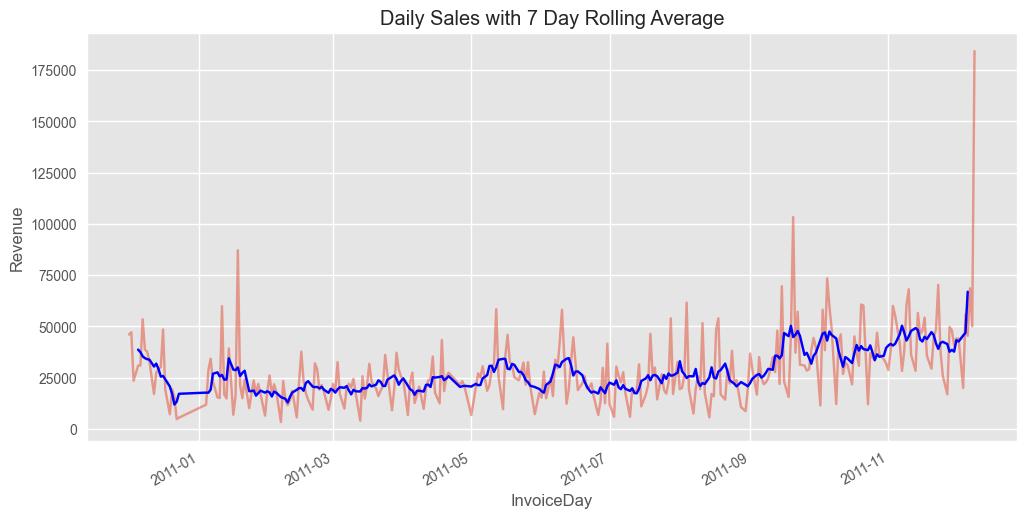

--------------------------------------------------------------------------------------------------------------------------------------------


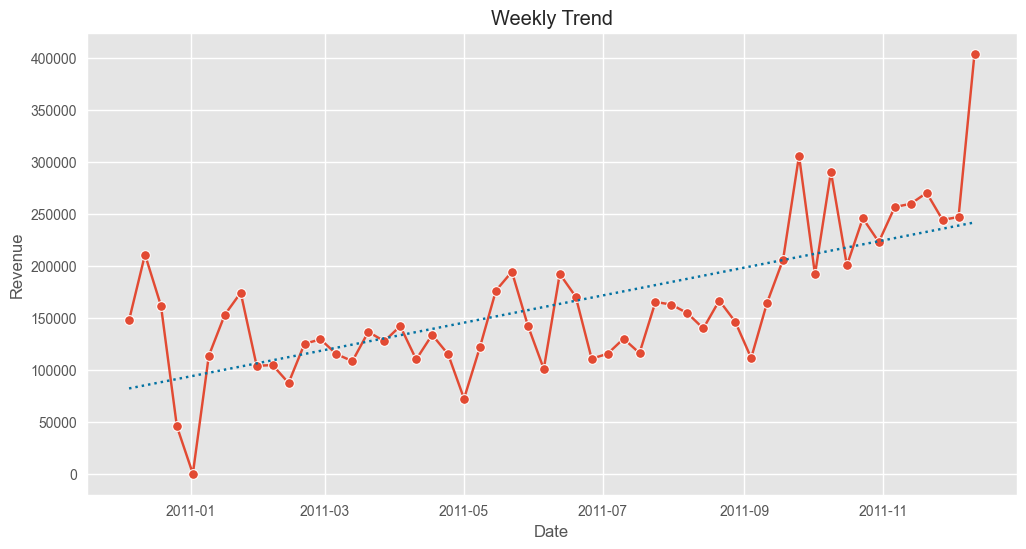

In [23]:
# Daily Trend
daily_sales = completed_transactions.groupby("InvoiceDay")["Revenue"].sum()
rolling_avg = daily_sales.rolling(window = 7, center = True).mean()

# Plot for Daily Trend with 7-day Rolling Avg
ax = daily_sales.plot(alpha = 0.5)
rolling_avg.plot(ax = ax, color = "blue")
plt.title("Daily Sales with 7 Day Rolling Average")
plt.ylabel("Revenue")
plt.show()
print("-"*140)
# Weekly Trend - For weekly trend, we need to resample our dataset to weekly
weekly_sales = daily_sales.resample("W").sum().reset_index()

# Weekly Trend Plot
sns.lineplot(x='InvoiceDay', y='Revenue', data=weekly_sales, marker='o')
plt.title("Weekly Trend")
plt.xlabel("Date")
# Linear regression for 'Revenue'
x = range(0, len(weekly_sales.index))
z = np.polyfit(x, weekly_sales['Revenue'], 1)
p = np.poly1d(z)
plt.plot(weekly_sales['InvoiceDay'], p(x), c='b', ls=':')
plt.show()

The weekly sales data for the past year show noticeable patterns and swings. The shop's revenue appears to have a slow start, as it fluctuates at irregular intervals from week 1 to week 40, reaching its lowest in week 5. After week 40, revenue steadily increases, hitting a new peak in week 43 before declining but remaining higher than in the previous periods, probably due to seasonal impacts. Notably, the most recent data point reflects a large spike in sales, setting a new record high, indicating a strong finish to the year. Overall, the online retail store's revenue exhibits a positive linear trajectory.

### Monthly Sales and Day of the Week Average Sales

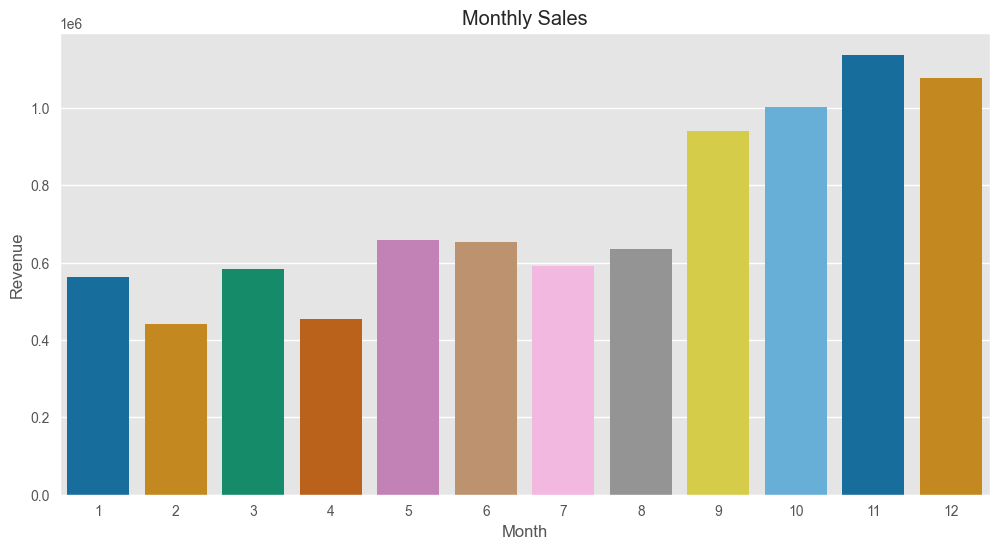

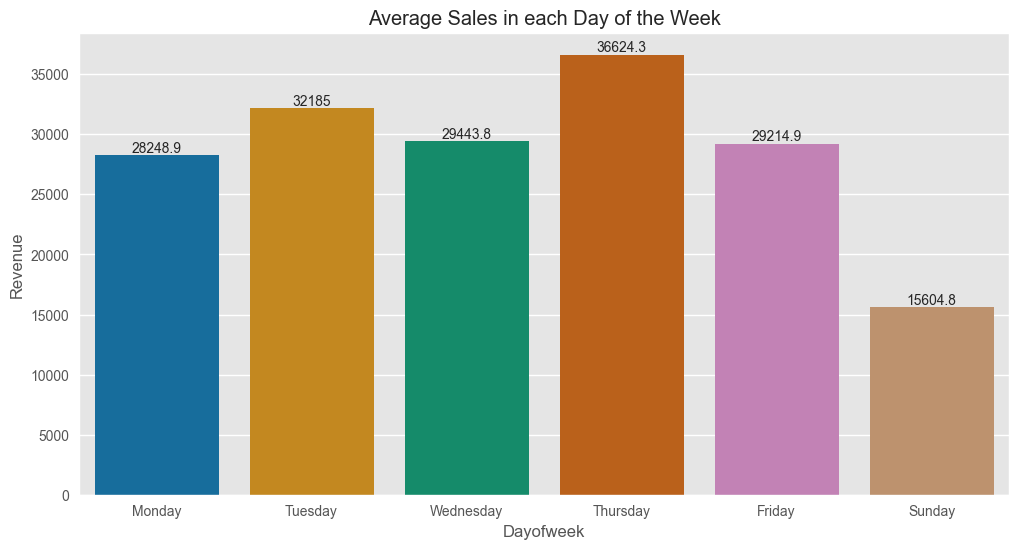

In [24]:
# Creating a Monthly Sales chart
monthly_sales = completed_transactions.groupby("Month")["Revenue"].sum().reset_index() 
sns.barplot(data = monthly_sales, x = "Month", y = "Revenue", palette = "colorblind")
plt.title("Monthly Sales")
plt.show()

# Creating Average Sales per day of the week chart
map_dayofweek = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 6: 'Sunday'}
avg_dayofweek_sales = completed_transactions.groupby(["InvoiceDay", "Dayofweek"])["Revenue"].sum().groupby("Dayofweek").mean().reset_index()
avg_dayofweek_sales.Dayofweek = avg_dayofweek_sales.Dayofweek.map(map_dayofweek)
ax = sns.barplot(data = avg_dayofweek_sales, x = "Dayofweek", y = "Revenue", palette = "colorblind")
ax.bar_label(ax.containers[0])
plt.title("Average Sales in each Day of the Week")
plt.show()

In the 'Monthly Sales' chart, we could observe that the lowest sales in a month was recorded on February while the highest on November. It is also noticeable that the sales in Q4 is above the other quarters. 
In the 'Day of the week chart', we could observe that Saturday is missing possibly due to having no sales or the store didn't accept transactions during this day. Furthermore, we could observe that the average sales during weekdays were much higher compared to weekends (Sunday). This could potentially indicates that the customers are more likely to shop during weekdays than in weekend.

### Analysis on Order Count

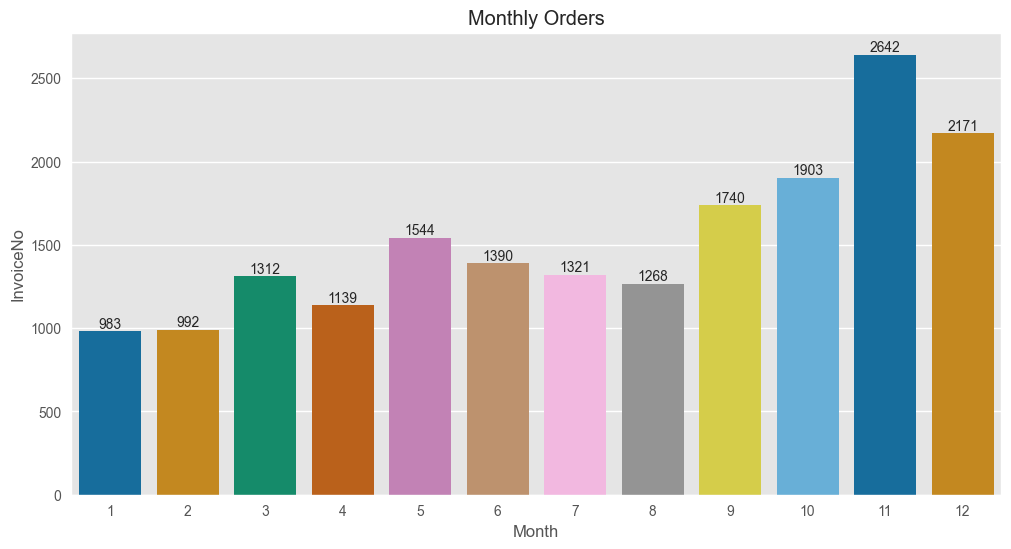

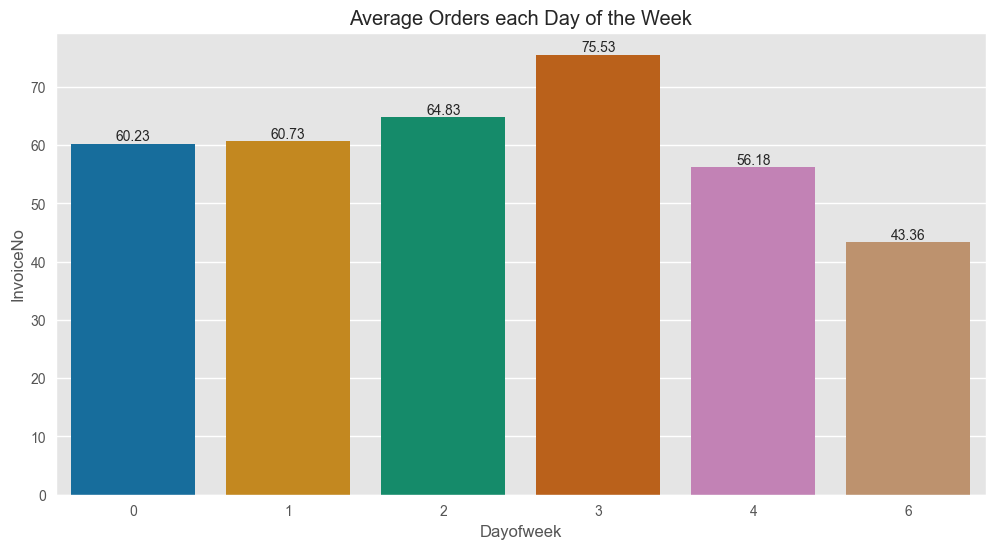

In [25]:
# Total Orders each Month
monthly_orders = completed_transactions.groupby("Month")["InvoiceNo"].nunique().reset_index()
ax = sns.barplot(data = monthly_orders, x = "Month", y = "InvoiceNo", palette = "colorblind")
ax.bar_label(ax.containers[0])
plt.title("Monthly Orders")
plt.show()

# Average Orders per Hour
dayofweek_orders = completed_transactions.groupby(["InvoiceDay", "Dayofweek"])["InvoiceNo"].nunique().groupby("Dayofweek").mean().reset_index()
dayofweek_orders.InvoiceNo = dayofweek_orders.InvoiceNo.apply(lambda x: round(x, 2))
ax = sns.barplot(data = dayofweek_orders, x = "Dayofweek", y = "InvoiceNo", palette = "colorblind")
ax.bar_label(ax.containers[0])
plt.title("Average Orders each Day of the Week")
plt.show()

The 'Monthly Orders' exhibit the same pattern as the 'Monthly Sales' so we could infer that there's a positive correlation between the two variables. Additionally, the retail store could expect an average of more than 50 orders each weekday while 43 on Sunday. 

### Hourly Unique User Visit 

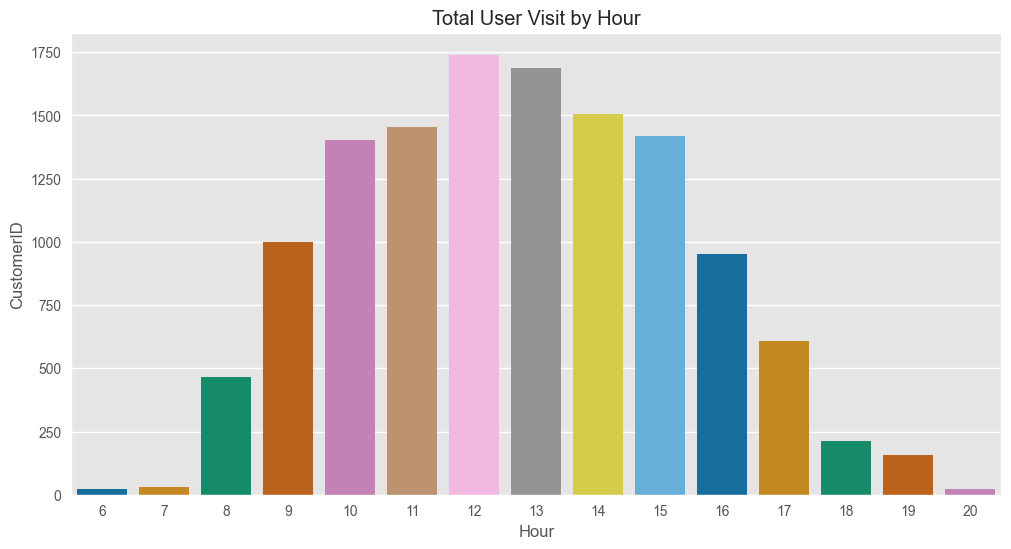

In [26]:
# Using the df dataframe to include both completed and cancelled orders 
dummy_df = df.copy()
dummy_df["Hour"] = dummy_df.InvoiceDate.dt.hour
dummy_df["InvoiceDay"] = dummy_df.InvoiceDate.dt.date
#avg_hourly_user_visit = dummy_df.groupby(["InvoiceDay", "Hour"])["CustomerID"].nunique().groupby("Hour").mean().reset_index()
avg_hourly_user_visit = dummy_df.groupby("Hour")["CustomerID"].nunique().reset_index()
# Plot
sns.barplot(data = avg_hourly_user_visit, x = "Hour", y = "CustomerID", palette = "colorblind")
plt.title("Total User Visit by Hour")
plt.show()

The hourly user visit exhibits an interesting pattern. During early morning (6 to 8 am), it can be observed that the number of visits is low, possibly because many people wake up and start their day. Activities such as breakfast, commuting to work, and getting ready for school or work also typically occur during this period. Subsequently, user engagement gradually increased, reaching its peak at 12pm before declining during the latter hours. This pattern suggests that the majority of visitors tend to engage with the retail site during the mid-morning to early afternoon hours, while user interest wanes towards the evening. This shows that it is ideal to post advertisements or promotions at 11 am or before 12 pm, as this is when the most people visit the store.

### Product Analysis
This section display the Top 10 Products by Revenue and Most Frequent Product Combinations.

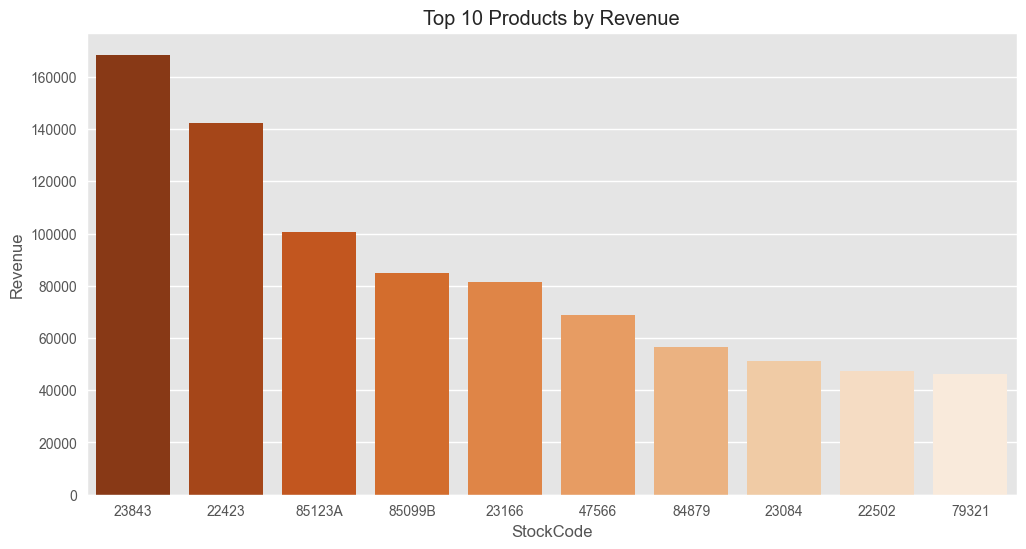

In [27]:
# Top 10 Products by Revenue
top10_products = completed_transactions.groupby("StockCode")["Revenue"].sum().sort_values(ascending = False).reset_index().head(10)
sns.barplot(data = top10_products, x = "StockCode", y = "Revenue", palette = "Oranges_r")
plt.title("Top 10 Products by Revenue")
plt.show()

TOP Combinations:
('LUNCH BAG RED RETROSPOT', 'LUNCH BAG PINK POLKADOT') - 317
('JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT') - 314
('LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.') - 303
('ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER') - 294
('ALARM CLOCK BAKELIKE RED ', 'ALARM CLOCK BAKELIKE GREEN') - 280
('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED ') - 269
('REGENCY CAKESTAND 3 TIER', 'ROSES REGENCY TEACUP AND SAUCER ') - 269
("PAPER CHAIN KIT 50'S CHRISTMAS ", 'PAPER CHAIN KIT VINTAGE CHRISTMAS') - 267
('RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER') - 266
('GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER ') - 263


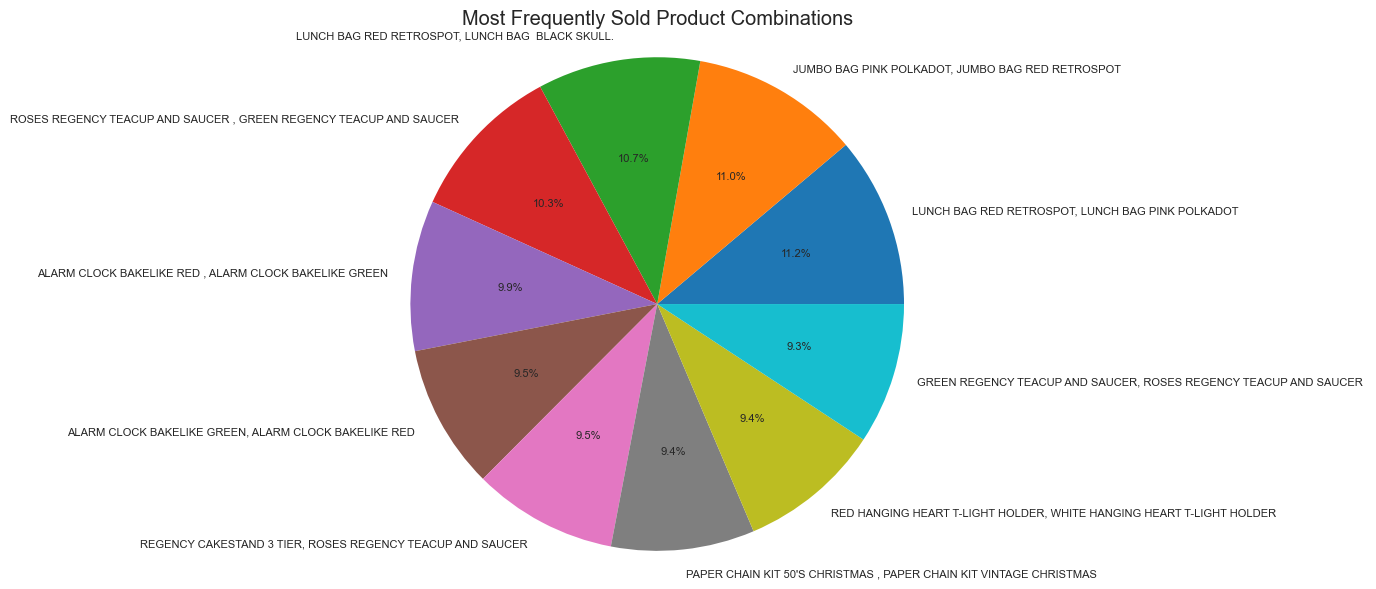

In [28]:
# Most Frequently Sold Product Combinations
dummy_df = completed_transactions.copy()
dummy_df.Description = dummy_df.Description.str.replace(",", "")

# Join the products together in a column
dummy_df["Grouped"] = dummy_df.groupby('InvoiceNo')['Description'].transform(lambda x: ','.join(x))

# Only include InvoiceNo and Grouped column and drop duplicates
dummy_df = dummy_df[['InvoiceNo', 'Grouped']].drop_duplicates()

# Create a combinations of two products
count = Counter() # Counter object from collections library

for row in dummy_df['Grouped']:
    products = row.split(',')
    count.update(combinations(products, 2))

# Specify the number of top combinations 
n = 10
top_combinations = count.most_common(n)

print("TOP Combinations:")
for combination, count in top_combinations:
    print(combination, "-", count)
    
# Creating a list 
combinations = [', '.join(comb) for comb, count in top_combinations] # Create a list of the top combination products
counts = [count for comb, count in top_combinations] # List of the total number of combinations for each combined products

# Plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.pie(counts, labels=combinations, autopct='%1.1f%%', textprops={'fontsize': 8}, colors = colors)
plt.title('Most Frequently Sold Product Combinations')
plt.axis('equal')  # Equal aspect ratio to ensure a circular pie chart
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

### Geographic Analysis

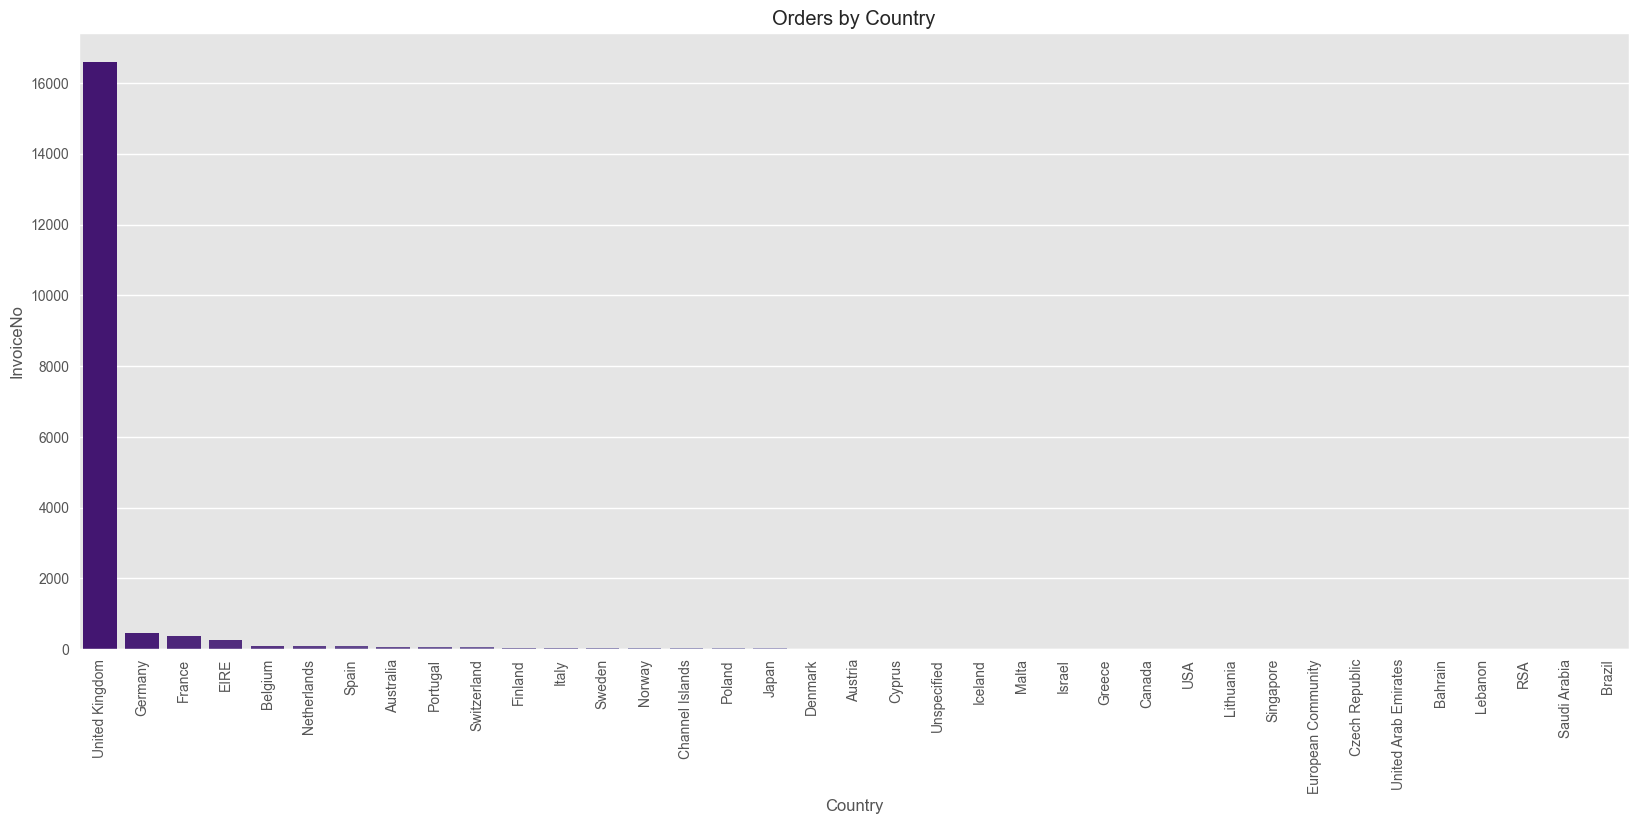

In [29]:
# Number of Orders by Country
plt.figure(figsize = (20,8))
orders_by_country = completed_transactions.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index()
sns.barplot(data = orders_by_country, x = "Country", y = "InvoiceNo", palette = "Purples_r")
plt.title("Orders by Country")
plt.xticks(rotation = 90)
plt.show()

Most of the orders are from the United Kingdom, while a comparatively small number come from the other 36 countries. This suggests that the store enjoys a significant local customer base but lacks substantial international popularity.

## Feature Engineering

### RFM Features

#### Recency
- How recently a customer has made a purchase

In [30]:
# Getting the latest date in the dataset
latest_date = completed_transactions.InvoiceDay.max()

# Getting the date of the most recent purchase of every customer
customers_data = completed_transactions.groupby("CustomerID")["InvoiceDay"].max().reset_index()

# Creating 'Recency' variable 
customers_data["Recency"] = (latest_date - customers_data["InvoiceDay"]).dt.days
customers_data.head()

,CustomerID,InvoiceDay,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


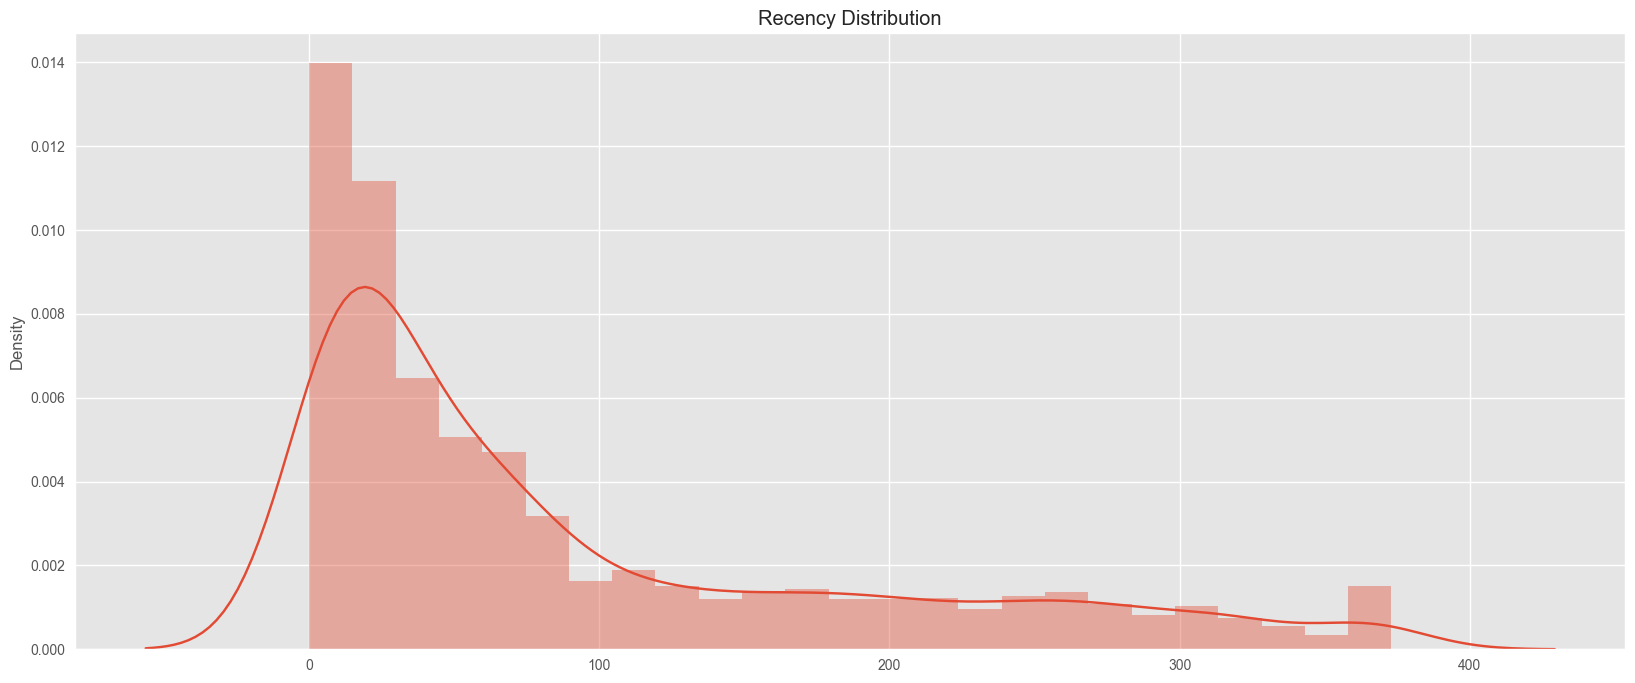

In [31]:
# Plotting the distribution of recency values
plt.figure(figsize = (20,8))
sns.distplot(x = customers_data.Recency)
plt.title("Recency Distribution")
plt.show()

The recency values exhibit a positive skew in their distribution, with the majority of the values falling within the range of 0 to 100.

#### Frequency
- How often a customer makes a purchase

In [32]:
# Getting the total transactions of each customer
total_transactions = completed_transactions.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()

# Getting the total number of products purchased per customer
total_products = completed_transactions.groupby("CustomerID")["Quantity"].sum().reset_index()

# Calculating the average time between purchases 
dummy_df = completed_transactions.copy()
dummy_df["AverageDaysBetweenPurchase"] = dummy_df.groupby("CustomerID")["InvoiceDay"].diff().dt.days
average_days_between_purchase = dummy_df.groupby("CustomerID")["AverageDaysBetweenPurchase"].mean().reset_index().dropna()

# Calculating the frequency of cancelleaion by each customer
cancellation_freq = cancelled_orders.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
cancellation_freq = cancellation_freq.rename(columns = {"InvoiceNo": "CancellationFrequency"})

# Merging all the Frequency related features to the customers_data
customers_data = customers_data.merge(total_transactions, how = "left", on = "CustomerID")
customers_data = customers_data.merge(total_products, how = "left", on = "CustomerID")
customers_data = customers_data.merge(average_days_between_purchase, how = "left", on = "CustomerID")
customers_data = customers_data.merge(cancellation_freq, how = "left", on = "CustomerID")

# Rename the columns
customers_data = customers_data.rename(columns = {"InvoiceNo": "TotalTransactions"})

# Fill NaN values with 0
customers_data = customers_data.fillna(0)

customers_data.head()

,CustomerID,InvoiceDay,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency
0,12346.0,2011-01-18,325,1,74215,0.000000,1.0
1,12347.0,2011-12-07,2,7,2458,2.016575,0.0
2,12348.0,2011-09-25,75,4,2332,10.884615,0.0
3,12349.0,2011-11-21,18,1,630,0.000000,0.0
4,12350.0,2011-02-02,310,1,196,0.000000,0.0


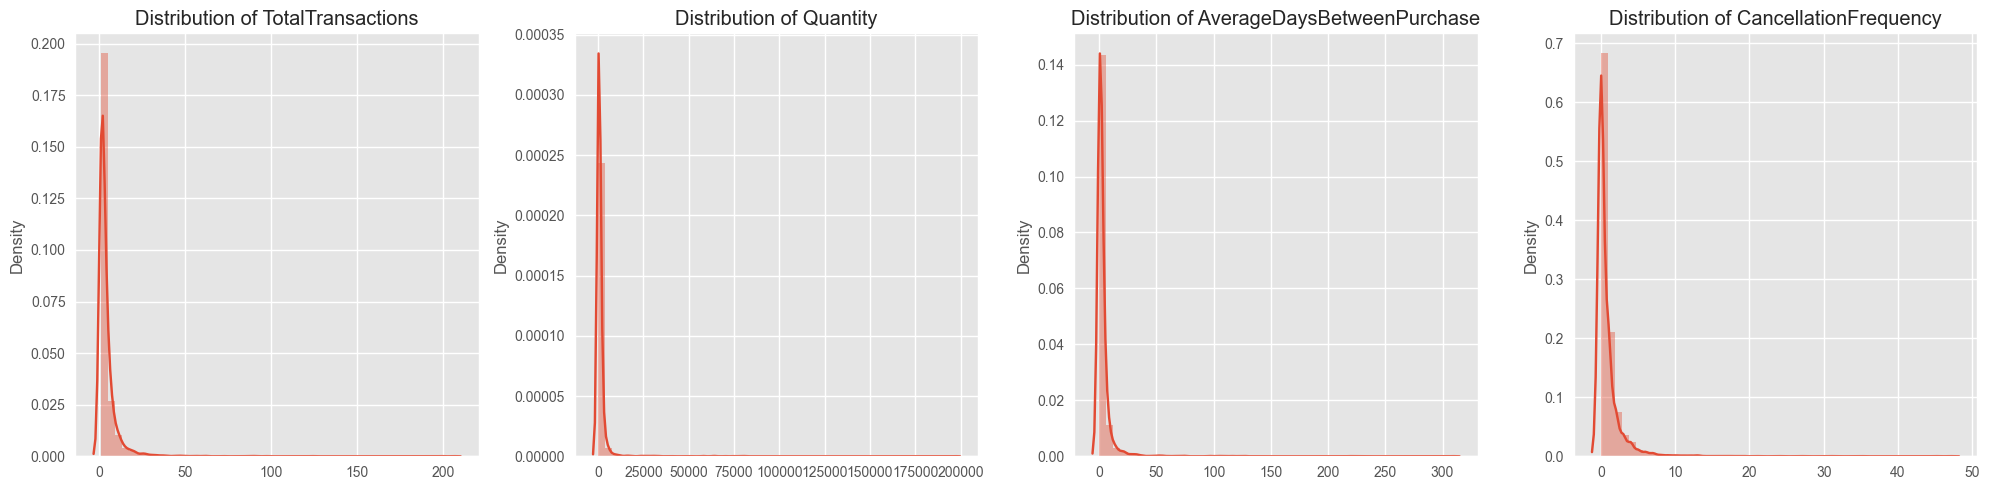

In [33]:
# Plotting the distribution of 'Frequency' features
fig = plt.figure(figsize = (20, 5))
gs = fig.add_gridspec(1, 4, width_ratios=(1, 1, 1, 1))

columns_to_plot = customers_data.iloc[:, 3:].columns.tolist()

for i, column in enumerate(columns_to_plot):
    ax = fig.add_subplot(1, 4, i + 1)
    sns.distplot(x = customers_data[column], ax = ax)
    plt.title(f"Distribution of {column}")
    plt.tight_layout()

The distribution of values in 'Frequency' related features are also positively skewed.

#### Monetary
- How much money a customer spends on purchases

In [34]:
# Getting the total purchased made by each customer
total_revenue = completed_transactions.groupby("CustomerID")["Revenue"].sum().reset_index()

# Getting the average revenue per transaction
average_revenue = completed_transactions.groupby(["CustomerID", "InvoiceNo"])["Revenue"].sum().groupby("CustomerID").mean().reset_index()

# Getting the average monthly revenue by customer
monthly_avg = completed_transactions.groupby(["CustomerID", "Month"])["Revenue"].sum().groupby("CustomerID").mean().reset_index()

# Merge the Monetary features to customers_data
customers_data = customers_data.merge(total_revenue, how = "left", on = "CustomerID")
customers_data = customers_data.merge(average_revenue, how = "left", on = "CustomerID")

# Rename columns 
customers_data = customers_data.rename(columns = {"Revenue_x": "TotalRevenue", "Revenue_y": "AverageRevenuePerTransaction"})
customers_data.head()

,CustomerID,InvoiceDay,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction
0,12346.0,2011-01-18,325,1,74215,0.000000,1.0,77183.60,77183.600000
1,12347.0,2011-12-07,2,7,2458,2.016575,0.0,4310.00,615.714286
2,12348.0,2011-09-25,75,4,2332,10.884615,0.0,1437.24,359.310000
3,12349.0,2011-11-21,18,1,630,0.000000,0.0,1457.55,1457.550000
4,12350.0,2011-02-02,310,1,196,0.000000,0.0,294.40,294.400000


### Additional Features

In [35]:
# Creating a variable to determing if the customer is from UK
completed_transactions["from_UK"] = {}
completed_transactions.loc[completed_transactions.Country.eq("United Kingdom"), "from_UK"] = 1
completed_transactions = completed_transactions.fillna(0)

customer_loc = completed_transactions.groupby("CustomerID")["from_UK"].mean().reset_index()
customer_loc = customer_loc.fillna(0)

# Favorite shopping day of each customer
fav_shopping_day = completed_transactions.groupby(["CustomerID", "Dayofweek"])["InvoiceNo"].nunique().reset_index()
fav_shopping_day = fav_shopping_day.loc[fav_shopping_day.groupby("CustomerID")["InvoiceNo"].idxmax()].drop("InvoiceNo", axis = 1)

# Favorite hour to shop
fav_shopping_hour = completed_transactions.groupby(["CustomerID", "Hour"])["InvoiceNo"].nunique().reset_index()
fav_shopping_hour = fav_shopping_hour.loc[fav_shopping_hour.groupby("CustomerID")["InvoiceNo"].idxmax()].drop("InvoiceNo", axis = 1)

# Merge the dataframes
customers_data = customers_data.merge(customer_loc, how = "left", on = "CustomerID")
customers_data = customers_data.merge(fav_shopping_day, how = "left", on = "CustomerID")
customers_data = customers_data.merge(fav_shopping_hour, how = "left", on = "CustomerID")
customers_data.head()

,CustomerID,InvoiceDay,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction,from_UK,Dayofweek,Hour
0,12346.0,2011-01-18,325,1,74215,0.000000,1.0,77183.60,77183.600000,1.0,1,10
1,12347.0,2011-12-07,2,7,2458,2.016575,0.0,4310.00,615.714286,0.0,1,14
2,12348.0,2011-09-25,75,4,2332,10.884615,0.0,1437.24,359.310000,0.0,1,10
3,12349.0,2011-11-21,18,1,630,0.000000,0.0,1457.55,1457.550000,0.0,0,9
4,12350.0,2011-02-02,310,1,196,0.000000,0.0,294.40,294.400000,0.0,2,16


In [36]:
# Removing InvoiceDay column
customers_data = customers_data.drop("InvoiceDay", axis = 1)

## Removing Outliers

In [37]:
# Summary Statistics
customers_data.describe()

,CustomerID,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction,from_UK,Dayofweek,Hour
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,92.226581,4.246654,1186.413936,3.208376,0.833872,2017.515838,415.673276,0.903553,2.163129,11.925704
std,1721.994109,100.175327,7.642535,5040.956561,10.461634,2.146514,8920.363571,1800.858885,0.295237,1.790406,2.281994
min,12346.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.750000,3.750000,0.000000,0.000000,6.000000
25%,13812.250000,17.000000,1.000000,159.250000,0.000000,0.000000,304.305000,177.197500,1.000000,1.000000,10.000000
50%,15297.500000,50.000000,2.000000,377.500000,1.081560,0.000000,663.710000,289.770000,1.000000,2.000000,12.000000
75%,16778.750000,142.000000,5.000000,989.750000,2.982759,1.000000,1631.622500,423.770750,1.000000,3.000000,13.000000
max,18287.000000,373.000000,206.000000,196844.000000,309.000000,47.000000,279138.020000,84236.250000,1.000000,6.000000,20.000000


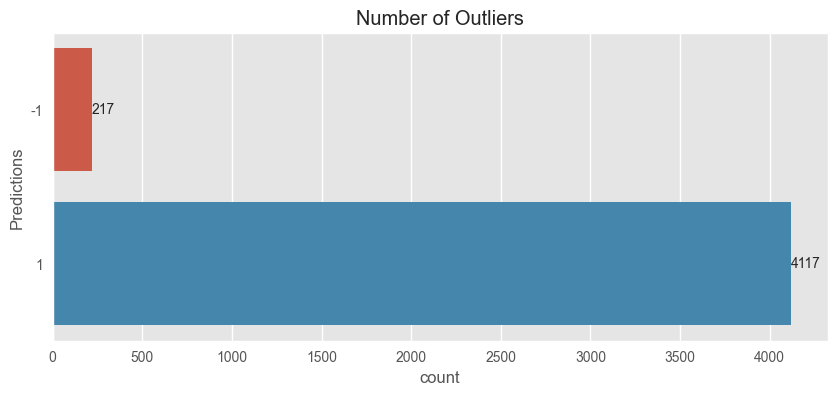

In [38]:
# Creating an IsolationForest object
isf = IsolationForest(contamination=0.05, random_state = 16)

# Creating a column to store the predictions. Isolation Forest label outliers as -1 and inliers as 1
customers_data["Predictions"] = isf.fit_predict(customers_data.iloc[:, 1:].to_numpy())

# Checking the number of outliers in the dataset
plt.figure(figsize = (10, 4))
ax = sns.countplot(data = customers_data, y = "Predictions")
ax.bar_label(ax.containers[0])
plt.title("Number of Outliers")
plt.show()

In [39]:
# Removing outliers in the dataset
customers_data = customers_data.loc[customers_data.Predictions.eq(1)]

# Dropping the 'Predictions' column
customers_data = customers_data.drop("Predictions", axis = 1)

# Setting the index to CustomerID
customers_data = customers_data.set_index("CustomerID")

# Dataframe shape and summary statistics after removing outliers
display(customers_data.shape)
print("-"*140)
display(customers_data.describe())

(4117, 10)

--------------------------------------------------------------------------------------------------------------------------------------------


,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction,from_UK,Dayofweek,Hour
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,93.095701,3.503522,707.088657,2.672801,0.624970,1178.992274,332.588306,0.921788,2.157639,11.942677
std,99.512651,3.678372,949.393459,5.245535,1.191661,1516.662378,252.871229,0.268538,1.794786,2.270703
min,0.000000,1.000000,1.000000,0.000000,0.000000,3.750000,3.750000,0.000000,0.000000,6.000000
25%,18.000000,1.000000,154.000000,0.000000,0.000000,297.000000,174.858667,1.000000,1.000000,10.000000
50%,52.000000,2.000000,354.000000,1.089552,0.000000,628.780000,279.770000,1.000000,2.000000,12.000000
75%,144.000000,4.000000,873.000000,3.000000,1.000000,1448.210000,406.090000,1.000000,3.000000,13.000000
max,373.000000,39.000000,10159.000000,70.000000,12.000000,14353.400000,3861.000000,1.000000,6.000000,20.000000


## Correlation Analysis

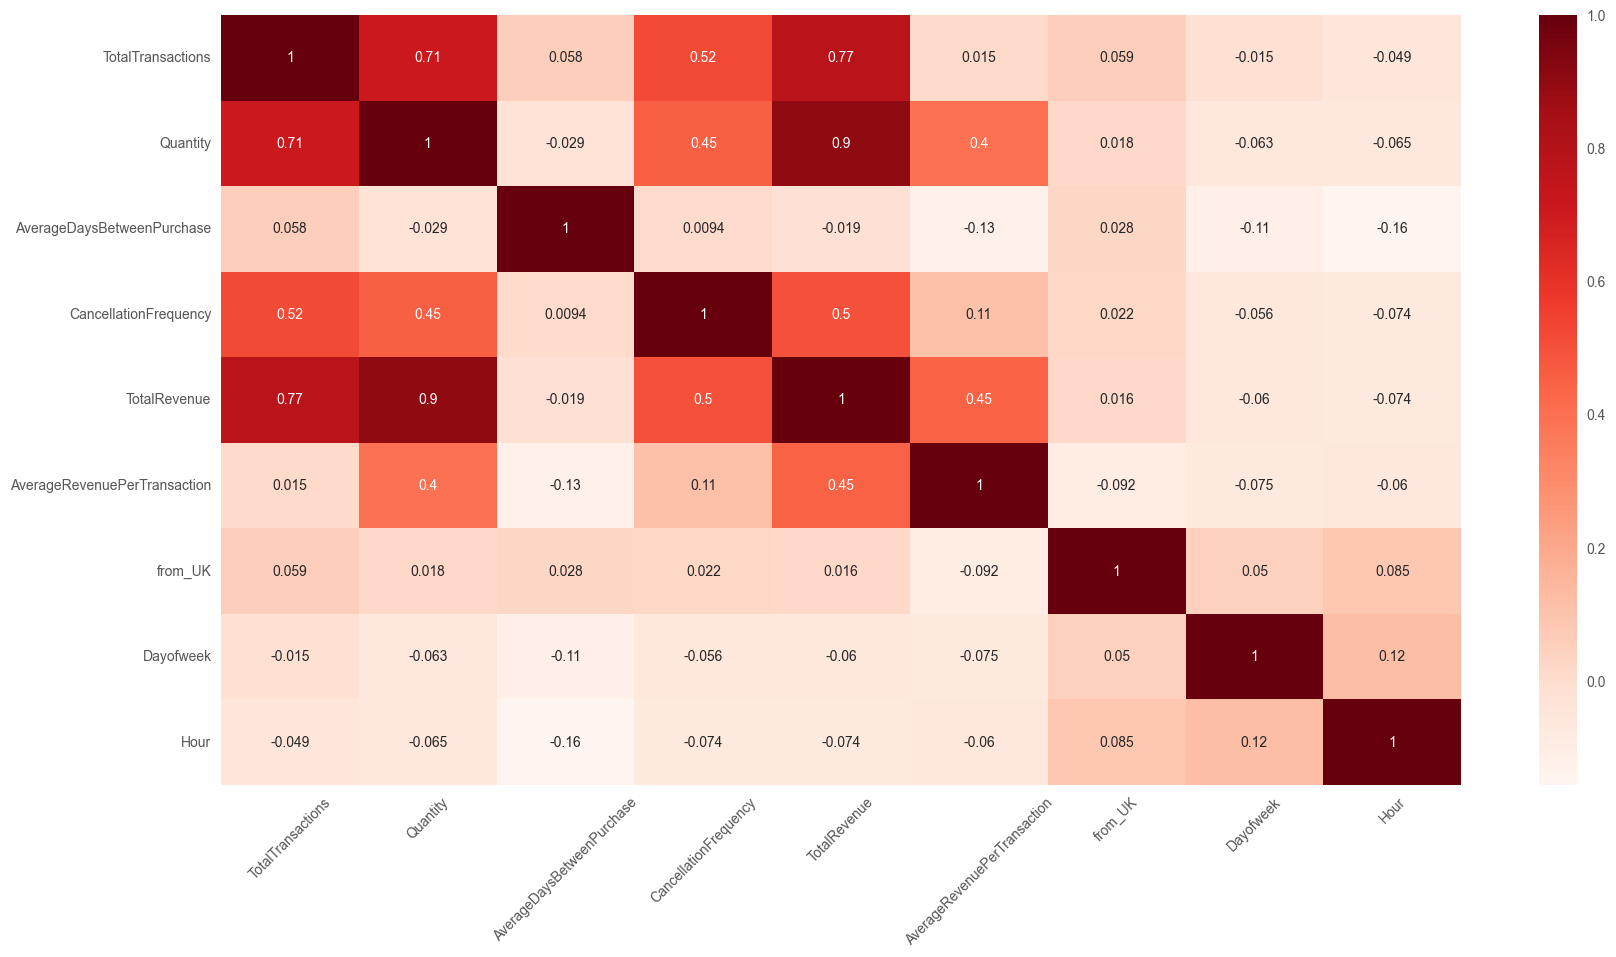

In [40]:
# Creating a heatmap to visualize the correlation between variables
plt.figure(figsize = (20, 10))
sns.heatmap(data = customers_data.iloc[:, 1:].corr(), annot = True, cmap = "Reds")
plt.xticks(rotation = 45)
plt.show()

By examining the heatmap, we can discern strong correlations between variables. For instance, TotalTransactions is highly correlated to the Quantity, CancellationFrequency, and TotalRevenue variables, vice versa.

## Feature Scaling
Scaling the dataset is an important step in this project because KMeans Algorithm is strongly reliant on distance measurements between data points. With features of varying scales, the impact of larger scale factors can dominate the clustering process, resulting in biased and poor outcomes.

In [41]:
# Creating a scaler object
scaler = StandardScaler()

# Define the columns to scale
columns_to_scale = ['Recency', 'TotalTransactions', 'Quantity',
       'AverageDaysBetweenPurchase', 'CancellationFrequency', 'TotalRevenue',
       'AverageRevenuePerTransaction', 'Hour']

# Scale
customers_data_scaled = customers_data.copy()
customers_data_scaled[columns_to_scale] = scaler.fit_transform(customers_data_scaled[columns_to_scale])

customers_data_scaled.head()

,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction,from_UK,Dayofweek,Hour
CustomerID,,,,,,,,,,
12347.0,-0.915529,0.950666,1.844466,-0.125117,-0.524516,2.064657,1.119781,0.0,1,0.906139
12348.0,-0.181865,0.134989,1.711734,1.565677,-0.524516,0.170294,0.105686,0.0,1,-0.855644
12349.0,-0.754726,-0.680689,-0.081208,-0.509600,-0.524516,0.183687,4.449294,0.0,0,-1.296090
12352.0,-0.573823,0.950666,-0.190765,0.142663,1.993284,0.136334,-0.532452,0.0,1,0.906139
12354.0,1.396015,-0.680689,-0.186551,-0.509600,-0.524516,-0.065673,2.953687,0.0,3,0.465694


## Dimensionality Reduction
Dimensionality reduction refers to the process of reducing the number of features in a dataset while keeping as much of the variation in the original dataset as possible. This is essential to improve the effectiveness of the KMeans clustering algorithm. By reducing the number of dimensions of the dataset, we can reduct the noise in the dataset, and ensure that clusters are based on the most important features. This can also enhance computational efficiency.In this project, I am going to apply Principal Component Analysis or PCA to reduce the dimension of the dataset. 

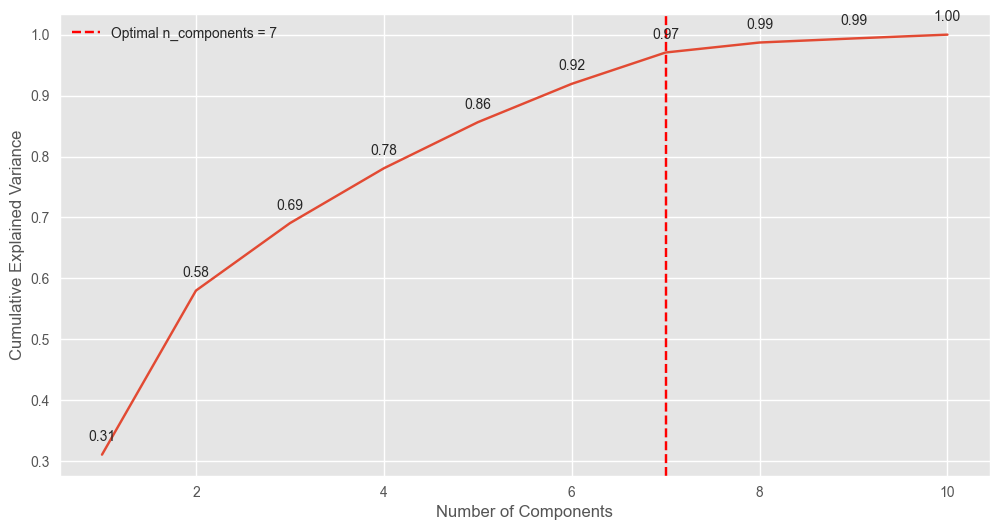

In [42]:
# Applying PCA to scaled_df
pca = PCA()
pca.fit(customers_data_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Using a 0.95 threshold to determine the most useful features
threshold = 0.95

# Finding the optimal number of components
optimal_n_components = np.argmax(cumulative_variance >= threshold) + 1

# Plot explained variance
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance)
plt.axvline(x=optimal_n_components, color='red', linestyle='--', label=f'Optimal n_components = {optimal_n_components}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Add labels to the data points
for i, var in enumerate(cumulative_variance):
    plt.annotate(f'{var:.2f}', (i + 1, var), textcoords="offset points", xytext=(0, 10), ha='center')

# Add legend
plt.legend()

plt.show()

In [43]:
# Creating a PCA object using the optimal number of components
pca = PCA(n_components = 7)

# Fit and Transform
pca_data = pca.fit_transform(customers_data_scaled)

# Converting the numpy array to a dataframe
columns = ['PC'+str(i+1) for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_data, index = customers_data_scaled.index, columns = columns)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
CustomerID,,,,,,,
12347.0,2.682273,1.117567,-1.057137,-0.239810,1.462083,0.115675,-1.076499
12348.0,1.639060,-0.330725,0.983401,0.985183,0.485342,0.707731,-0.950143
12349.0,2.242696,-1.170883,-2.363096,3.319151,1.533153,-0.432071,1.038393
12352.0,1.536323,0.019561,0.538243,-1.673752,-0.408778,0.087885,1.366959
12354.0,-0.861274,0.323840,-2.567786,1.582508,0.642927,1.234099,0.402714
...,...,...,...,...,...,...,...
18280.0,0.242403,-2.794778,-0.425760,0.580447,-1.771627,0.113607,-0.691804
18281.0,-3.813420,1.590854,0.443761,0.698909,-1.081538,-0.330683,-0.354149
18282.0,-1.630087,0.693516,2.198135,0.259126,0.375982,0.062686,0.710343


## Customer Segmentation using KMeans

### Finding the Optimal Number of Clusters for KMeans

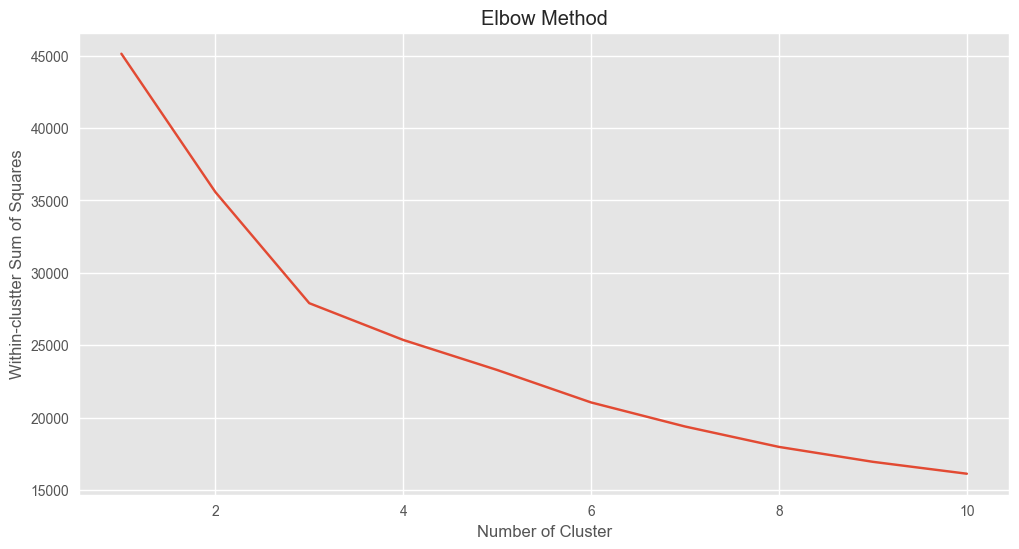

In [44]:
# Using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pca_df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

# Plot
n_clusters = range(1, 11)
plt.plot(n_clusters, wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Cluster")
plt.ylabel("Within-clustter Sum of Squares")
plt.show()

In applying the elbow method to our dataset, we observed an "elbow" point at three clusters. This observation is based on the significant decrease in inertia up to three clusters. However, after three clusters, we noticed that the decrease in inertia began to slow down. This suggests that adding more clusters did not lead to significant improvement. To further prove this, we can use Silhouette Score to measure the quality of clusters where the closer the score to 1, the better.

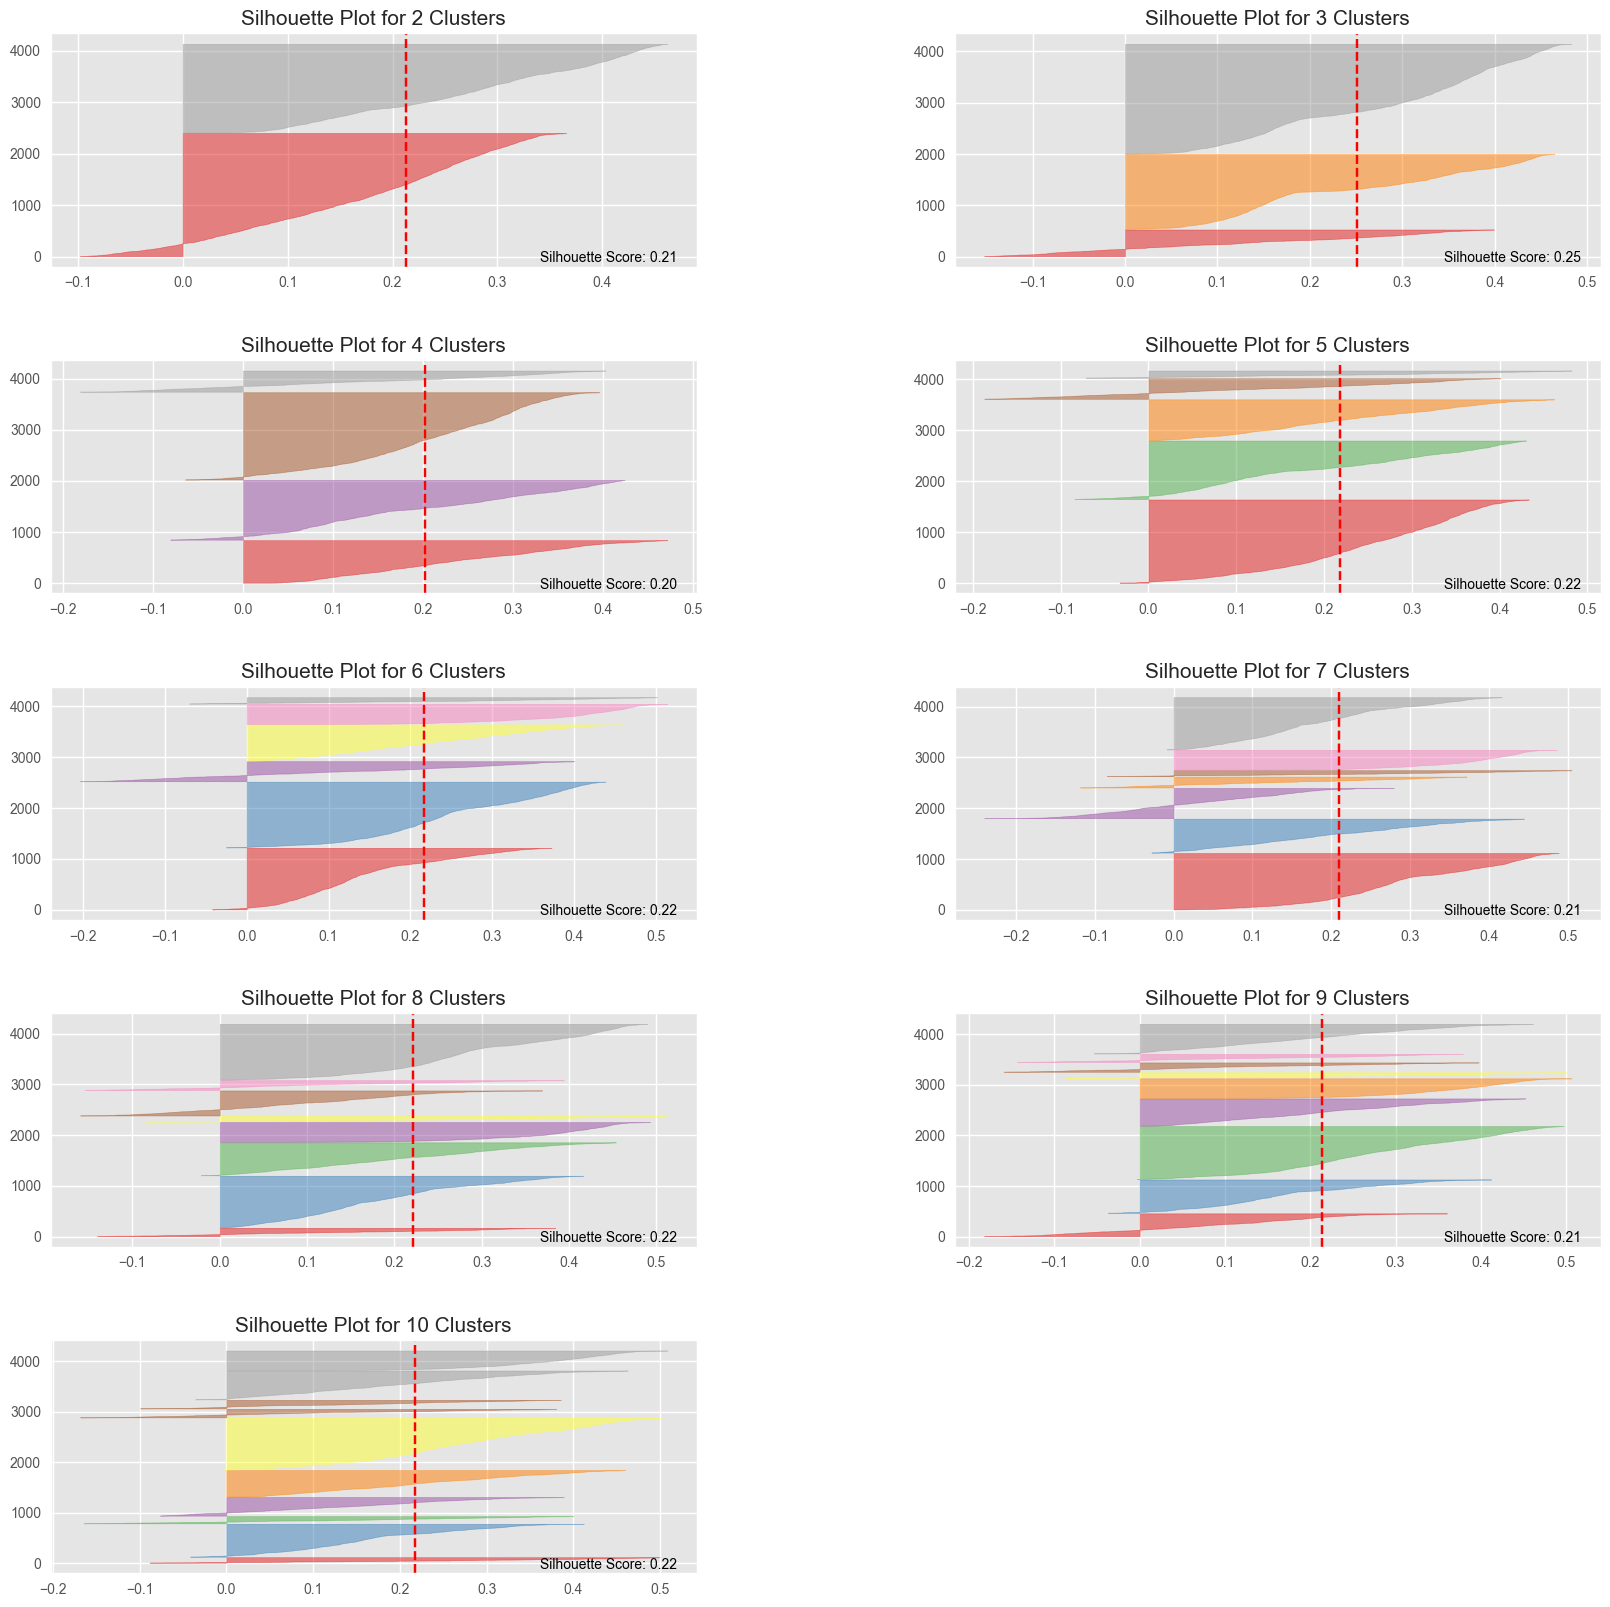

In [45]:
# In this code, we use SilhouetteVisualizer to create a silhouette plot
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(5, 2, wspace=0.4, hspace=0.4)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    row_idx, col_idx = divmod(i - 2, 2) 

    # Assign the plots to the grid
    ax = plt.subplot(gs[row_idx, col_idx])  

    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(pca_df)

    # Add the Silhouette score text to the plot
    score = silhouette_score(pca_df, kmeans.labels_)
    ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', ha='right', transform=ax.transAxes, color='black')

    ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

plt.tight_layout()
plt.show()

Another method to select the optimal n cluster is to use 'Calinski Harabasz' Score. In this method, the optimal number of clusters corresponds to the solution with the highest Calinski-Harabasz index value.

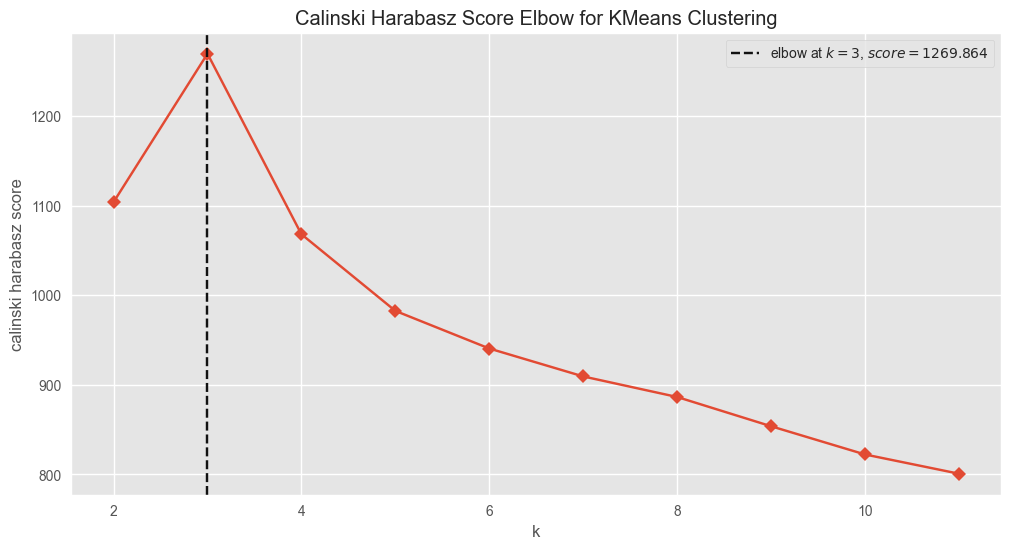

In [46]:
# Using the KElbowVisualizer to visualize the CH score
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz', timings=False)
visualizer.fit(pca_df)       
visualizer.show() 
plt.show()

### Model Training and Clustering

In [47]:
# Creating a KMeans object with the optimal n clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state = 0)

# Fit and Predict
cluster_predictions = kmeans.fit_predict(pca_df)

# Get the frequency of each cluster
cluster_frequencies = Counter(cluster_predictions)

# Sort the clusters by frequency in ascending order
sorted_clusters = sorted(cluster_frequencies, key=lambda x: cluster_frequencies[x])

# Create a mapping from old labels to new labels based on sorted order
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in cluster_predictions])

# Adding the predictions to customers_data dataframe
pca_df["Cluster"] = new_labels
customers_data["Cluster"] = new_labels
customers_data.head()

,Recency,TotalTransactions,Quantity,AverageDaysBetweenPurchase,CancellationFrequency,TotalRevenue,AverageRevenuePerTransaction,from_UK,Dayofweek,Hour,Cluster
CustomerID,,,,,,,,,,,
12347.0,2,7,2458,2.016575,0.0,4310.00,615.714286,0.0,1,14,0
12348.0,75,4,2332,10.884615,0.0,1437.24,359.310000,0.0,1,10,2
12349.0,18,1,630,0.000000,0.0,1457.55,1457.550000,0.0,0,9,2
12352.0,36,7,526,3.421053,3.0,1385.74,197.962857,0.0,1,14,2
12354.0,232,1,530,0.000000,0.0,1079.40,1079.400000,0.0,3,13,1


### Cluster Analysis

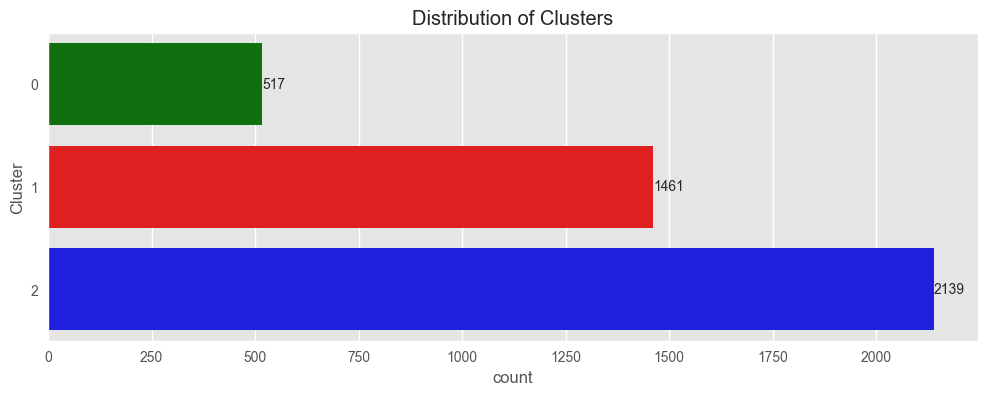

In [60]:
# Define cluster colors
colors = ["green", "red", "blue"]

plt.figure(figsize = (12, 4))
ax = sns.countplot(data = customers_data, y = "Cluster", palette= colors)
ax.bar_label(ax.containers[0])
plt.title("Distribution of Clusters")
plt.show()

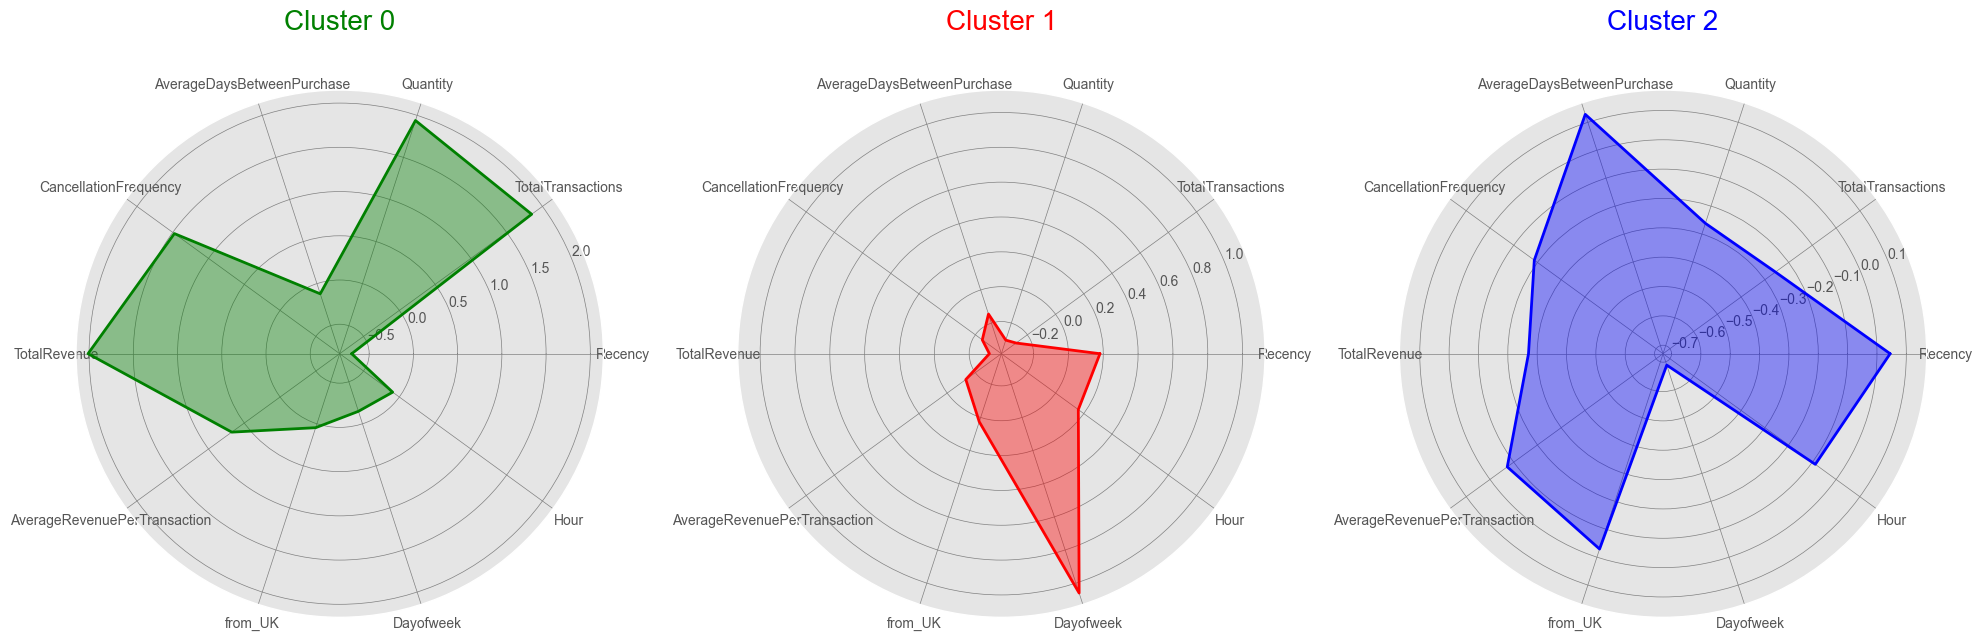

In [61]:
# Load and standardize data
#df_customer = customers_data.copy()
df_customer_standardized = StandardScaler().fit_transform(customers_data.drop(columns=['Cluster'], axis=1))
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=customers_data.columns[:-1], index=customers_data.index)
df_customer_standardized['Cluster'] = customers_data['Cluster']

# Calculate cluster centroids
cluster_centroids = df_customer_standardized.groupby('Cluster').mean()
# Set data and angles
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Create radar charts for each cluster
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)
for i, (color, data) in enumerate(zip(colors, cluster_centroids.values)):
    data = np.append(data, data[0])  # Complete the loop
    ax[i].fill(angles, data, color=color, alpha=0.4)
    ax[i].plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax[i].set_title(f'Cluster {i}', size=20, color=color, y=1.1)
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])
    ax[i].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

### Cluster Profiling

<span style="font-size: larger; color: green;">Cluster 0 Profile: Frequent Shoppers with Strong Spending Habits</span>
- Customers in this cluster are frequent and recent shoppers, reflecting their active engagement with the online retail store. They consistently make purchases with minimal gaps in between, demonstrating a strong commitment to shopping.
- The time intervals between their purchases are consistently short as indicated by a low AverageDaysBetweenPurchase. This suggests that they maintain a regular shopping routine and tend to return to make new purchases shortly after previous transactions.
- This cluster brought in a huge amount of revenue for the store as indicated by a high TotalRevenue value. These customers are high-value shoppers, consistently driving revenue growth. While their spending per transaction is moderate (AverageRevenuePerTransaction), it's important to note that their cumulative spending is high. This means that while they may not make big single purchases, their frequent buying patterns lead to significant overall spending.
- Customers' engagement in this cluster is exceptionally strong, as evidenced by the high TotalTransactions. Additionally, they purchase a substantial quantity of products, as evidenced by a high Quantity value.
- They prefer shopping during early weekdays, particularly during the morning to noon period, reflecting a weekday-oriented shopping behavior that begins in the morning.
- However, it's noteworthy that they tend to cancel orders frequently as indicated by a high CancellationFrequency. This could imply that customers in this cluster exhibit a tendency to change their minds or make adjustments to their orders.

<span style="font-size: larger; color: red;">**Cluster 1 Profile: Infrequent Shoppers**.</span>
- Most customers in this cluster made their last transactions a long time ago as evident from their high Recency value.
- But during their transactions period, they tend to shop at low time intervals as indicated by the low AverageDaysBetweenPurchase value.
- They tend to spend less, with a lower number of transactions and quantity purchased, and also displayed infrequent engagement in cancellations.
- They prefer shopping during the late weekdays or Sundays, typically in the morning to noon period.

<span style="font-size: larger; color: blue;">**Cluster 2 Profile: Occasional Big Spenders**.</span>
- Customers in this cluster exhibit the characteristics of being occasional shoppers, as evident from both their high Recency and AverageDaysBetweenPurchase values. This implies that they tend to make purchases with longer intervals between transactions, signifying a less frequent shopping pattern compared to the previous cluster.
- They engage in a relatively lower number of transactions (TotalTransactions), but when they shop, they tend to spend significantly on individual purchases, as indicated by the high AverageRevenuePerTransaction. This suggests that when these customers decide to shop, they do so with a generous budget.
- While this cluster contributes a moderate amount of revenue to the store, their focus on spending big during occasional shopping trips is worth noting. 
- Most of the customers in this cluster are from United Kingdom as indicated by a high 'from_UK' value.
- They also prefer shopping during early weekdays, particularly during the afternoon, 
- In terms of order cancellation, this cluster exhibits similarity to the previous one, with customers occasionally canceling their orders, although not as frequently.

## Forecasting
In this stage, we will the completed_transactions dataframe, which contains all the completed transactions in the dataset. The primary objective here is to create a consistent datetime frequency for our analysis, specifically hourly data. To achieve this, we will perform the following steps:

1. Extracting Relevant Features: We begin by extracting the "InvoiceDate" and "Revenue" column from the dataframe. This will allow us to work with the datetime and target features.

2. Resampling the Data: Resampling is a method to transform our time series dataset into having an hourly interval or frequency. It combines an aggregation method that will allow us to get the hourly Revenue.

3. Handling Outliers: We then check if there's any outlier in the dataset using the IQR method.

4. Creating a Time Series Features: The resulting dataframe will represent a time series, where each row corresponds to a specific datetime, and the columns contain the features. 

In [50]:
# Making a copy of completed_transactions dataframe
completed_transactions_copy = completed_transactions.copy()

# Checking the summary statistics
completed_transactions_copy.describe()

,Quantity,UnitPrice,CustomerID,is_Cancelled,Revenue,Month,Quarter,Dayofweek,Hour,from_UK
count,391283.000000,391283.000000,391283.000000,391283.0,391283.000000,391283.000000,391283.000000,391283.000000,391283.000000,391283.000000
mean,13.141174,2.890437,15294.928975,0.0,22.346776,7.602459,2.852743,2.607611,12.722751,0.891687
std,180.777238,4.375279,1710.146581,0.0,310.880067,3.414825,1.121330,1.924559,2.276132,0.310776
min,1.000000,0.040000,12346.000000,0.0,0.060000,1.000000,1.000000,0.000000,6.000000,0.000000
25%,2.000000,1.250000,13969.000000,0.0,4.950000,5.000000,2.000000,1.000000,11.000000,1.000000
50%,6.000000,1.950000,15157.000000,0.0,11.900000,8.000000,3.000000,2.000000,13.000000,1.000000
75%,12.000000,3.750000,16794.000000,0.0,19.800000,11.000000,4.000000,4.000000,14.000000,1.000000
max,80995.000000,649.500000,18287.000000,0.0,168469.600000,12.000000,4.000000,6.000000,20.000000,1.000000


Upon examining the summary statistics, we have identified the presence of outliers in the "Quantity" and "Revenue" columns. Note that these outliers can cause bias to our analysis and modeling, resulting in inaccurate results. It is crucial to handle these outliers by removing them from our dataset in order to ensure the robustness and reliability of our forecasting.

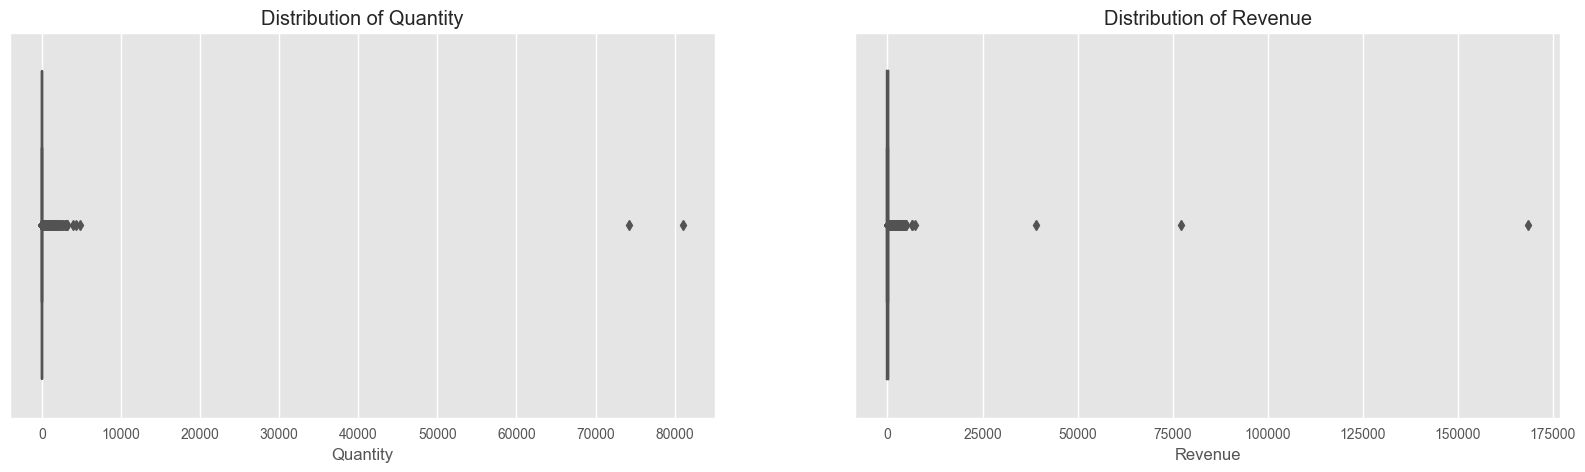

In [51]:
fig = plt.figure(figsize = (20, 5))
gs = fig.add_gridspec(1,2)

# Visualizing Outliers in 'Quantity' and 'Revenue' using Box Plot
sns.boxplot(data = completed_transactions_copy, x = "Quantity", ax=fig.add_subplot(gs[0, 0]))
plt.title("Distribution of Quantity")

sns.boxplot(data = completed_transactions_copy, x = "Revenue", ax=fig.add_subplot(gs[0, 1]))
plt.title("Distribution of Revenue")
plt.show()

### Handling Outliers using IsolationForest

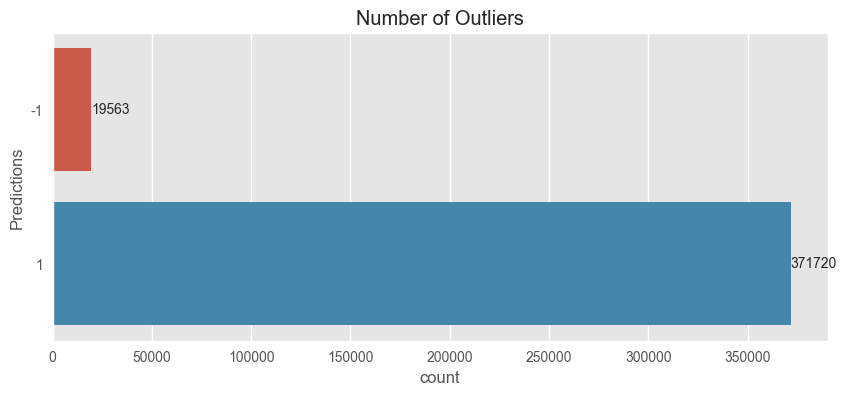

In [52]:
# Creating an IsolationForest object
isf = IsolationForest(contamination = 0.05, random_state = 142)

# Creating a column to store the predictions. Isolation Forest label outliers as -1 and inliers as 1
completed_transactions_copy["Predictions"] = isf.fit_predict(completed_transactions_copy[["Quantity", "Revenue"]].to_numpy())

# Checking the number of outliers in the dataset
plt.figure(figsize = (10, 4))
ax = sns.countplot(data = completed_transactions_copy, y = "Predictions")
ax.bar_label(ax.containers[0])
plt.title("Number of Outliers")
plt.show()

In [53]:
# Removing the outlierse from the dataframe
completed_transactions_copy = completed_transactions_copy.loc[completed_transactions_copy.Predictions.eq(1)]
completed_transactions_copy.describe()

,Quantity,UnitPrice,CustomerID,is_Cancelled,Revenue,Month,Quarter,Dayofweek,Hour,from_UK,Predictions
count,371720.000000,371720.000000,371720.000000,371720.0,371720.000000,371720.000000,371720.000000,371720.000000,371720.000000,371720.000000,371720.0
mean,7.924814,2.822056,15306.146193,0.0,13.576338,7.616160,2.857828,2.623302,12.753013,0.898461,1.0
std,8.606834,3.011404,1709.309311,0.0,12.255443,3.413497,1.121064,1.938047,2.265783,0.302041,0.0
min,1.000000,0.060000,12347.000000,0.0,0.060000,1.000000,1.000000,0.000000,6.000000,0.000000,1.0
25%,2.000000,1.250000,13982.000000,0.0,4.350000,5.000000,2.000000,1.000000,11.000000,1.000000,1.0
50%,5.000000,1.950000,15184.000000,0.0,10.500000,8.000000,3.000000,2.000000,13.000000,1.000000,1.0
75%,12.000000,3.750000,16807.000000,0.0,17.700000,11.000000,4.000000,4.000000,14.000000,1.000000,1.0
max,56.000000,65.000000,18287.000000,0.0,82.800000,12.000000,4.000000,6.000000,20.000000,1.000000,1.0


### Feature Engineering

In [54]:
# Creating a time-series data
forecasting_df = completed_transactions_copy[['InvoiceDate', 'Revenue']].set_index("InvoiceDate")

# Resampling the dataset to hourly frequency
forecasting_df = forecasting_df.resample("H").sum()

# Creating datetime features
forecasting_df["Year"] = forecasting_df.index.year
forecasting_df["quarter"] = forecasting_df.index.quarter
forecasting_df["Month"] = forecasting_df.index.month
forecasting_df["dayofweek"] = forecasting_df.index.dayofweek
forecasting_df["hour"] = forecasting_df.index.hour

# Determine whether the day of week is Saturday as the store don't have any transactions during this day
forecasting_df["is_saturday"] = {}
forecasting_df.loc[forecasting_df.dayofweek.eq(5), "is_saturday"] = 1

# Fill NaN with 0
forecasting_df = forecasting_df.fillna(0)

forecasting_df.head()

,Revenue,Year,quarter,Month,dayofweek,hour,is_saturday
InvoiceDate,,,,,,,
2010-12-01 08:00:00,1149.81,2010,4,12,2,8,0.0
2010-12-01 09:00:00,2304.34,2010,4,12,2,9,0.0
2010-12-01 10:00:00,2399.79,2010,4,12,2,10,0.0
2010-12-01 11:00:00,3195.96,2010,4,12,2,11,0.0
2010-12-01 12:00:00,3968.60,2010,4,12,2,12,0.0


### Spltting the Dataset into Train and Test Sets

In [55]:
# Split the dataset into training and test set. The training set will contain 
# transactions before 2011-12-01 while the test set is after that period. 
train = forecasting_df.loc[forecasting_df.index < "2011-12-01"]
test = forecasting_df.loc[forecasting_df.index >= "2011-12-01"]

# Declaring X and y
X_train = train.drop("Revenue", axis = 1)
y_train = train.Revenue
X_test = test.drop("Revenue", axis = 1)
y_test = test.Revenue

### HyperParameter Tuning using GridSearchCV

In [56]:
# model = XGBRegressor(random_state = 142)

# params = {
#     "n_estimators": [100, 200, 300, 400],
#     "max_depth": [3, 6, 9],
#     "gamma": [0.001, 0.01, 0.1],
#     "learning_rate": [0.001, 0.01, 0.1]  
# }

# GS = GridSearchCV(estimator = model, param_grid = params, scoring = 'neg_mean_absolute_error', verbose = 4)
# GS.fit(X_train, y_train)

# best_params = GS.best_params_
# best_params_score = GS.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Score: {best_params_score}")

### Model Training and Evaluation

In [57]:
# Copying the best parameters identified by GridSearchCV
params = {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}

# Creating an XGBoost model with the best parameters
model = XGBRegressor(random_state = 1, **params)

# Fitting the dataset into the model
model.fit(X_train, y_train)

# Making Predictions
y_pred = model.predict(X_test)

# Measuring the accuracy in terms of Mean-Absolute Error and Mean-absolute Percentage Error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# We can also perform cross validation to our dataset to ensure the robustness of the model
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_absolute_error")
mean_accuracy = -np.mean(cv_scores)

print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Mean CV Score: {mean_accuracy}")

Mean Absolute Error: 314.83199466760493
RMSE: 772.532356169176
Mean CV Score: 325.41565787987867


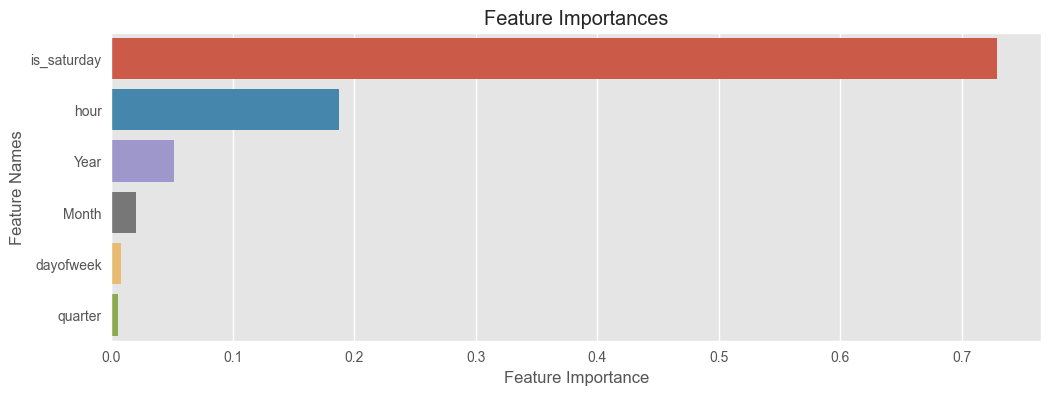

In [58]:
# Check the Feature importances
feature_names = X_train.columns
feature_importance = model.feature_importances_

# Creating a dataframe for feature importances
feature_importances_df = pd.DataFrame({"Feature Names": feature_names, "Feature Importance": feature_importance})
feature_importances_df = feature_importances_df.sort_values(by = "Feature Importance", ascending = False)

# Plot
plt.figure(figsize = (12, 4))
sns.barplot(data = feature_importances_df, x = "Feature Importance", y = "Feature Names")
plt.title("Feature Importances")
plt.show()

#### Plot the Predictions vs the True Values

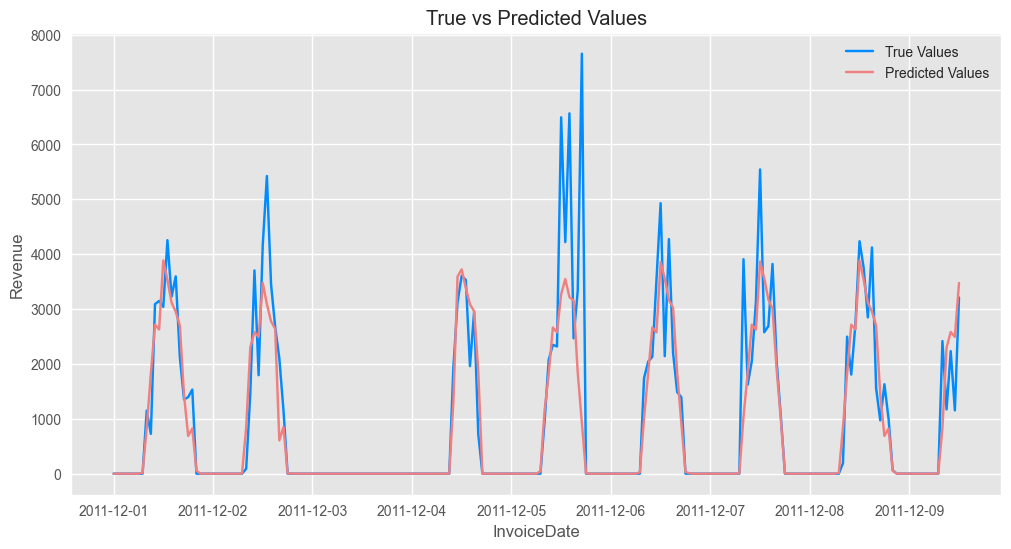

In [59]:
# Adding the predictions to the test dataframe
test["Predictions"] = y_pred

# Visualizing the difference between the predicted and true values
ax = sns.lineplot(data = test, x = "InvoiceDate", y = "Revenue", label = "True Values", color = "#008BFF")
sns.lineplot(data = test, x = "InvoiceDate", y = "Predictions", ax = ax, label = "Predicted Values", color = "#F08080")
ax.set_title("True vs Predicted Values")
plt.show()

#### Forecasting Conclusion

After conducting several feature engineering experiments, including feature lagging and a 24-hour rolling average, I found out that these additions did not enhance the model's accuracy or reduce the mean absolute error (MAE) in the context of this project. Consequently, these features were removed, and the model was trained solely on the remaining features. This refinement led to an approximately 314 MAE, demonstrating that the selected feature set provides the best predictive performance for the given task. Furthermore, as observed in the graph above, the predictions do not align perfectly with the true values. However, they do capture the underlying pattern or trend to a significant extent. 